# Text data with pytorch

##### 2.1 Word embedding:
## 2.1.1. Reading `txt` files, tokenizing texts and building a vocabulary
## 2.1.2. Define Vocabulary
## 2.1.3. Continous bag of words using embedding layer
- 2.1.4. Train models and evaluate performance
- 2.1.5. Compute cosine similarity matrix of the vocabulary based on the trained embedding
- 2.1.6. Visualize the embedding space

##### 2.2 Conjugating be and have:
- 2.2.1 Attention Layer
- 2.2.2. Train models and evaluate performance

##### 2.3 Text generation:
- 2.3.1. Next Word
- 2.3.2. Train models and evaluate performance
- 2.3.3. Beam Search
- 2.3.3. Sentence creation


_______________________________________________

# 2.1 Word embedding

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

import numpy as np

import os
import re
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.vocab import vocab as Vocab

from utils import set_device

import matplotlib.pyplot as plt

torch.manual_seed(265)
torch.set_default_dtype(torch.double)

from collections import Counter, OrderedDict

device = torch.device("cpu")
print(f"Device {device}.")


Device cpu.


Define the paths of the generated files to distribute the files in the system

In [ ]:
# Where we will store / load all our models, datasets, vocabulary, etc.
PATH_GENERATED = './generated/'
PATH_WORDS = "words/"
PATH_DATA = "data/"
PATH_MODELS = "models/"

## 2.1.1. Reading `txt` files, tokenizing texts and building a vocabulary

In [ ]:
# tokenizer will split a long text into a list of english words
TOKENIZER_EN = get_tokenizer('basic_english')

# Minimum number of occurence of a word in the text to add it to the vocabulary
MIN_FREQ = 100

# If you want to remove some characters to get rid of noise
# specials=["<unk>", ",", ".", "!", "?"] 
specials = []

# List of posible words to use
target_words = ["be", "am", "are", "is", "was", "were", "been", "being", "have", "has", "had", "having"]
taget_words_size = len(target_words) 


def read_files(datapath='./data_train/'):
    """
    Return a list of strings, one for each line in each .txt files in 'datapath'
    """
    # Find all txt files in directory 
    files = os.listdir(datapath)
    files = [datapath + f for f in files if f.endswith(".txt")]
    
    # Stores each line of each book in a list
    lines = []
    for f_name in files:
        with open(f_name) as f:
            lines += f.readlines()
    return lines

def tokenize(lines, tokenizer=TOKENIZER_EN):
    """
    Tokenize the list of lines
    """
    list_text = []
    for line in lines:
        list_text += tokenizer(line)
    return list_text

def yield_tokens(lines, tokenizer=TOKENIZER_EN):
    """
    Yield tokens, ignoring names and digits to build vocabulary
    """
    # Match any word containing digit
    no_digits = '\w*[0-9]+\w*' 
    # Match word containing a uppercase 
    no_names = '\w*[A-Z]+\w*'
    # Match any sequence containing more than one space
    no_spaces = '\s+'
    
    for line in lines:
        # Remove special characters
        line = ''.join([char for char in line if char not in specials])
        line = re.sub(no_digits, ' ', line)
        line = re.sub(no_names, ' ', line)
        line = re.sub(no_spaces, ' ', line)
        yield tokenizer(line)

def count_freqs(words, vocab):
    """
    Count occurrences of each word in vocabulary in the data
    
    Useful to get some insight on the data and to compute loss weights
    """

    vocab_stoi = vocab.get_stoi()

    freqs = torch.zeros(len(vocab), dtype=torch.int)
    for w in words:
        if w in vocab_stoi:
            freqs[vocab[w]] += 1
    return freqs

def create_vocabulary(lines, min_freq=MIN_FREQ, specials=None):
    """
    Create a vocabulary (list of known tokens) from a list of strings
    """
    if specials is None:
        specials = ["<unk>"]
    # vocab contains the vocabulary found in the data, associating an index to each word
    vocab = build_vocab_from_iterator(yield_tokens(lines), min_freq=min_freq, specials=specials)
    # Since we removed all words with an uppercase when building the vocabulary, we skipped the word "I"
    vocab.append_token("i")
    # Value of default index. This index will be returned when OOV (Out Of Vocabulary) token is queried.
    vocab.set_default_index(vocab["<unk>"])
    # SANITAZE THE INPUT, Get rid of the unkown words 

    return vocab

## 2.1.2. Define Vocabulary

In [ ]:
# ----------------------- Tokenize texts -------------------------------
# Load tokenized versions of texts if you have already generated it
# Otherwise, create it and save it

if os.path.isfile(PATH_GENERATED + PATH_WORDS +"words_train.pt"):
    words_train = torch.load(PATH_GENERATED + PATH_WORDS +"words_train.pt")
    words_val = torch.load(PATH_GENERATED + PATH_WORDS +"words_val.pt")
    words_test = torch.load(PATH_GENERATED + PATH_WORDS +"words_test.pt")
else:
    # Get lists of strings, one for each line in each .txt files in 'datapath' 
    lines_books_train = read_files('./data_train/')
    lines_books_val = read_files('./data_val/')
    lines_books_test = read_files('./data_test/')

    # List of words contained in the dataset
    words_train = tokenize(lines_books_train)
    words_val = tokenize(lines_books_val)
    words_test = tokenize(lines_books_test)
    
    torch.save(words_train , PATH_GENERATED + PATH_WORDS +"words_train.pt")
    torch.save(words_val , PATH_GENERATED + PATH_WORDS +"words_val.pt")
    torch.save(words_test , PATH_GENERATED + PATH_WORDS +"words_test.pt")


# ----------------------- Create vocabulary ----------------------------
VOCAB_FNAME = PATH_GENERATED + PATH_WORDS + "vocabulary.pt"
# Load vocabulary if you have already generated it
# Otherwise, create it and save it
if os.path.isfile(VOCAB_FNAME):
    vocab = torch.load(VOCAB_FNAME)
else:
    # Create vocabulary based on the words in the training dataset
    vocab = create_vocabulary(lines_books_train, min_freq=MIN_FREQ)
    torch.save(vocab, VOCAB_FNAME)
    


Now lets sanitaze the data we have

------------Normal Database---------------
Total number of words in the training dataset:              2684706
Total number of words in the validation dataset:            49526
Total number of words in the test dataset:                  124152
Number of distinct words in the training dataset:           52105
Number of distinct words kept (vocabulary size):            1880


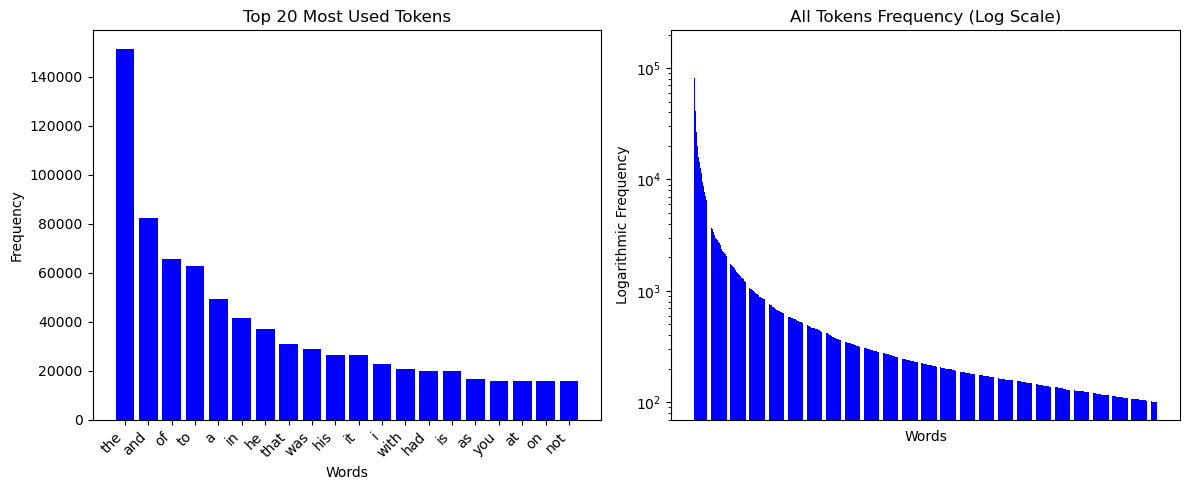

In [ ]:
# ------------------------ Quick analysis  ------------------------------

VOCAB_SIZE = len(vocab)
vocab_itos = vocab.get_itos()


print("------------Normal Database---------------")
print("Total number of words in the training dataset:             ", len(words_train))
print("Total number of words in the validation dataset:           ", len(words_val))
print("Total number of words in the test dataset:                 ", len(words_test))
print("Number of distinct words in the training dataset:          ", len(set(words_train)))
print("Number of distinct words kept (vocabulary size):           ", VOCAB_SIZE)

freqs = count_freqs(words_train, vocab)

occurrences = [(f.item(), w) for (f, w) in zip(freqs, vocab.lookup_tokens(range(VOCAB_SIZE)))]
specials = ["<unk>", ",", ".", "!", "?"]

# Filtrar las ocurrencias para eliminar palabras especiales
filtered_occurrences = [(freq, word) for freq, word in occurrences if word not in specials]
top_occurrences = sorted(filtered_occurrences, key=lambda x: x[0], reverse=True)

top_occurrences_words = []
top_occurrences_freq = []
for freq, word in top_occurrences:
    top_occurrences_words.append(word)
    top_occurrences_freq.append(freq)

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figsize to fit your display

# Bars Graph for Top 20 most used Tokens
axes[0].bar(top_occurrences_words[:20], top_occurrences_freq[:20], color='blue')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Top 20 Most Used Tokens')
axes[0].set_xticks(range(len(top_occurrences_words[:20])))
axes[0].set_xticklabels(top_occurrences_words[:20], rotation=45, ha='right')

# Bars Graph for All Words with a Logarithmic scale
axes[1].bar(top_occurrences_words, top_occurrences_freq, color='blue')
axes[1].set_yscale('log')  # Set the y-axis to a logarithmic scale
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Logarithmic Frequency')
axes[1].set_title('All Tokens Frequency (Log Scale)')
axes[1].set_xticks([])  # Optionally, remove x-tick labels for clarity

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()    

Prepare the weights value for the loss function

In [ ]:
import torch

epsilon = 1e-5
freqs_adjusted = freqs + epsilon  # Adjust frequencies to avoid zero

total_samples = torch.sum(freqs_adjusted)
class_weights_initial = total_samples / freqs_adjusted
class_weights = class_weights_initial / torch.sum(class_weights_initial)  # Normalize to sum to 1

print("Adjusted Frequencies:", freqs_adjusted)
print("Total Samples:", total_samples)
print("Initial Weights:", class_weights_initial)
print("Normalized Weights:", class_weights)


Adjusted Frequencies: tensor([1.0000e-05, 1.8254e+05, 1.5128e+05,  ..., 1.8200e+02, 1.0000e+02,
        2.2996e+04])
Total Samples: tensor(2250799.0188)
Initial Weights: tensor([2.2508e+11, 1.2331e+01, 1.4879e+01,  ..., 1.2367e+04, 2.2508e+04,
        9.7878e+01])
Normalized Weights: tensor([9.9991e-01, 5.4779e-11, 6.6098e-11,  ..., 5.4940e-08, 9.9991e-08,
        4.3482e-10])


Create the dataset

In [ ]:
def create_aroundTarget_dataset(text, vocab, before_context_size, after_context_size, target_words=None, target_to_idx=None):
    contexts = []
    targets = []
    lenText = len(text)

    # If specified target words are given
    if target_words is not None and target_to_idx is not None:

        for i in range(before_context_size, lenText - after_context_size):

            word = text[i]
            # Case if the target words are specified
            if word in target_words:

                t = target_to_idx[word]
                
                around = (
                    text[i - before_context_size : i]
                    + text[i + 1 : i + after_context_size + 1]
                )

                c = torch.Tensor([vocab[w] for w in around]).type(torch.long)

                # The index of the target has to be from 0 to 11 not the vocab one
                targets.append(t)
                contexts.append(c)

    # No target words were specified
    elif target_words is None and target_to_idx is None:
        
        #txt = [w for w in text]

        specials_idx = [vocab[special] for special in specials] # Dont use special characters for targets

        for i in range(before_context_size, len(text) - after_context_size):
            
            t = vocab[text[i]]

            if t not in specials_idx: # Dont use unk for targets to prevent the neuronal network from chosing it for every prediction

                around = (
                        text[i - before_context_size : i]
                        + text[i + 1 : i + after_context_size + 1]
                )

                c = torch.Tensor([vocab[w] for w in around]).type(torch.long)


                targets.append(t)
                contexts.append(c)

    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    return TensorDataset(contexts, targets)

def load_dataset(words, vocab, fname, before_context_size, after_context_size, target_words=None, target_to_idx=None):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    # If already generated
    if os.path.isfile(PATH_GENERATED + PATH_DATA + fname):
        dataset = torch.load(PATH_GENERATED+ PATH_DATA + fname)
        print(f"{fname} loaded from saved files.")
    else:
        # Create context / target dataset based on the list of strings
        dataset = create_aroundTarget_dataset(words, vocab, before_context_size, after_context_size, target_words=target_words, target_to_idx=target_to_idx)
        torch.save(dataset, PATH_GENERATED + PATH_DATA + fname)
        print(f"{fname} created.")
    return dataset


Create the dataset

In [ ]:
before_context_size= 5
after_context_size= 5
batch_size = 64

# Normal Data Train
data_train = load_dataset(words_train, vocab, "data_train.pt", before_context_size, after_context_size)
data_val = load_dataset(words_val, vocab, "data_val.pt", before_context_size, after_context_size)
data_test = load_dataset(words_test, vocab, "data_test.pt", before_context_size, after_context_size)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

print("Batch size: ", batch_size)
print("Total number of entries in the training dataLoader:   ", len(train_loader))
print("Total number of entries in the validation dataLoader: ", len(val_loader))
print("Total number of entries in the test dataLoader:       ", len(test_loader))

data_train.pt loaded from saved files.
data_val.pt loaded from saved files.
data_test.pt loaded from saved files.
Batch size:  64
Total number of entries in the training dataLoader:    30038
Total number of entries in the validation dataLoader:  566
Total number of entries in the test dataLoader:        1310


Check that the train data is well created

In [ ]:
def showDataSet(train_data, selected_vocab, index, before_context, after_context):
    start, end = index
    if start > end or start <0 or end>len(train_data): 
        print("Wrong indexes numbers")
        return

    for i in range(*index):
        input_tensor, target_tensor = train_data[i]
        input_tensor = input_tensor.tolist()
        target_tensor = target_tensor.item()

        phrase = ""

        # Add context before target
        for value in input_tensor[:before_context]:
            phrase += selected_vocab[value] + " "

        # Add the target word with with ** between
        phrase += " *"+ selected_vocab[target_tensor] + "* "

        # Add contexr after target
        if after_context > 0:
            for value in input_tensor[-after_context:]:
                phrase += selected_vocab[value] + " "

        # Print
        print(" Input: ", input_tensor," Target: ", target_tensor, "-> {", selected_vocab[target_tensor], "}""\n   -> {", phrase.strip(),  "}")

index = (45,55) # for example
print("\n************** Tensors-> 5 Words before, 5 after examples: **************")
showDataSet(data_train, vocab_itos, index, 5, 5)
        


************** Tensors-> 5 Words before, 5 after examples: **************
 Input:  [24, 0, 1, 62, 761, 2, 1015, 5, 0, 8]  Target:  21 -> { for }
   -> { be <unk> , if merely  *for* the sake of <unk> in }
 Input:  [0, 1, 62, 761, 21, 1015, 5, 0, 8, 29]  Target:  2 -> { the }
   -> { <unk> , if merely for  *the* sake of <unk> in all }
 Input:  [1, 62, 761, 21, 2, 5, 0, 8, 29, 1480]  Target:  1015 -> { sake }
   -> { , if merely for the  *sake* of <unk> in all points }
 Input:  [62, 761, 21, 2, 1015, 0, 8, 29, 1480, 1]  Target:  5 -> { of }
   -> { if merely for the sake  *of* <unk> in all points , }
 Input:  [21, 2, 1015, 5, 0, 29, 1480, 1, 6, 0]  Target:  8 -> { in }
   -> { for the sake of <unk>  *in* all points , to <unk> }
 Input:  [2, 1015, 5, 0, 8, 1480, 1, 6, 0, 137]  Target:  29 -> { all }
   -> { the sake of <unk> in  *all* points , to <unk> here }
 Input:  [1015, 5, 0, 8, 29, 1, 6, 0, 137, 2]  Target:  1480 -> { points }
   -> { sake of <unk> in all  *points* , to <unk> here t

As we can see sometimes getting rid of the unkwown characters could lead into a better understanding of the context

## 2.1.3. Continous bag of words using embedding layer

Model 1. Model Simple. No activation function, linear tranformations

In [ ]:
class CBOWSimple(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, before_context_size, after_context_size):
        super(CBOWSimple, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim * (before_context_size + after_context_size), hidden_dim) # Before and after
        self.linear2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((inputs.shape[0], -1))
        out = self.linear1(embeds)
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

Model 2. A bit more complex, relu activation, bigger embedding when training

In [ ]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, before_context_size, after_context_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim * (before_context_size + after_context_size), hidden_dim) # Before and after
        self.linear2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((inputs.shape[0], -1))
        out = self.linear1(embeds)
        out = F.relu(out) # Adding ReLU activation function for non-linearity
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

Model 3. The most complex, 2 linear layers, dropout layer

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CBOWComplex(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, before_context_size, after_context_size):
        super(CBOWComplex, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # Linear layer to transform embedded input into hidden space
        self.linear1 = nn.Linear(embedding_dim * (before_context_size + after_context_size), hidden_dim)
        
        # Adding an extra linear layer for more complex transformations
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)
        
        # Final linear layer that maps hidden states to vocabulary size for prediction
        self.linear3 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, inputs):
        # Embedding inputs
        embeds = self.embeddings(inputs).view((inputs.shape[0], -1))
        
        # Passing embeddings through the first linear layer
        out = self.linear1(embeds)
        out = F.relu(out)  # Adding ReLU activation function for non-linearity
        
        # Passing through the second linear layer
        out = self.linear2(out)
        out = F.relu(out)  # Adding ReLU activation function
        
        # Applying dropout
        out = self.dropout(out)
        
        # Final linear layer for predictions
        out = self.linear3(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


## 2.1.4. Train models and evaluate performance



Accuracy calculation

In [ ]:
def accuracy(model, loader):
    """
    Compute the accuracy of model with given data loader
    """
    model.eval()
    correct = 0
    with torch.no_grad():
        for contexts, labels in loader:
            contexts = contexts.to(device=device)
            labels = labels.to(device=device)

            outputs = model(contexts)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    return correct / len(loader.dataset)

Train model

In [ ]:

def train(n_epochs, optimizer, scheduler, model, loss_fn, train_loader, val_loader, device=None):
    device = set_device(device)

    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    loss_train = 0.0
    print(f"{datetime.now().time()} Starting train")
    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for contexts, targets in train_loader:

            contexts = contexts.to(device=device)
            targets = targets.to(device=device)

            outputs = model(contexts)

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        current_loss = loss_train / n_batch
        losses_train.append(current_loss)

        scheduler.step()  # Update the learning rate based on the scheduler
        
        if epoch == 1 or epoch % 5 == 0:
            # Check that the accuracy of the val model is still improving to prevent overfitting
            acc = accuracy(model, val_loader)
            train_acc = accuracy(model, train_loader)
            print('{}  |  Epoch {}  |  Training loss {:.5f} | Train accuracy: {:.2%} | Validation Accuracy: {:.2%} | lr: {:.6}'.format(
                datetime.now().time(), epoch, current_loss, train_acc, acc, scheduler.get_last_lr()[0]))
            
        # Check if the average of the last 5 losses is less than 0.001, early stopping
        if len(losses_train) >= 5:
            # Calculate the average of the last 5 recorded losses
            avg_loss = abs(sum(losses_train[-5:]) / 5)
            if avg_loss < 0.001:
                print('Average loss of the last 5 epochs is less than 0.001, stopping training.')
                break
    return losses_train

def relative_error(a, b):
    return torch.norm(a - b) / torch.norm(a)

Modelos

In [ ]:
titles = []
models = []

# use weights based on each class frequency 
# to alleviate the effects of class imbalance when training 
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights) 

CBOW_counter = 0 # Counter for the CBOW models we will do


We train a Simple model first

In [ ]:
filename = f"CBOW_{CBOW_counter+1}_Simple"
print(f"{CBOW_counter}.Training: {filename}")
CBOW_PATH = PATH_GENERATED + PATH_MODELS + filename + ".pt"
if os.path.isfile(CBOW_PATH):
    CBOW_model = torch.load(CBOW_PATH)
    print(f"\tLoaded From saved file")
else:
    # n_epochs = 100 # 1:30 mins epoch
    n_epochs = 100
    lr = 0.01
    embedding_dim = 16
    hidden_dim = 128

    CBOW_model = CBOWSimple(len(vocab), embedding_dim, hidden_dim, before_context_size, after_context_size).to(device=device)
    optimizer = optim.SGD(CBOW_model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.75)

    train(n_epochs=n_epochs, optimizer=optimizer, scheduler=scheduler, model=CBOW_model, loss_fn=loss_fn, train_loader=train_loader,val_loader=val_loader)
    torch.save(CBOW_model, CBOW_PATH)
    
CBOW_counter += 1
titles.append(filename)
models.append(CBOW_model)

0.Training: CBOW_1_Simple
	Loaded From saved file


We train the medium complex model with a higher emebedding dim, 128 instead of 16 and a hidden layer of 128

In [ ]:

filename = f"CBOW_{CBOW_counter+1}_Medium)"
print(f"{CBOW_counter}.Training: {filename}")
CBOW_PATH = PATH_GENERATED + PATH_MODELS + filename + ".pt"
if os.path.isfile(CBOW_PATH):
    CBOW_model = torch.load(CBOW_PATH)
    print(f"\tLoaded From saved file")
else:
    embedding_dim = 128
    hidden_dim = 256
    # n_epochs = 100 # 2 mins epoch
    n_epochs = 100
    lr = 0.01

    CBOW_model = CBOW(len(vocab), embedding_dim, hidden_dim, before_context_size, after_context_size).to(device=device)
    optimizer = optim.SGD(CBOW_model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


    train(n_epochs=n_epochs, optimizer=optimizer, scheduler=scheduler, model=CBOW_model, loss_fn=loss_fn, train_loader=train_loader,val_loader=val_loader)
    
    torch.save(CBOW_model, CBOW_PATH)

titles.append(filename)
models.append(CBOW_model)
CBOW_counter += 1


1.Training: CBOW_2_Medium)
	Loaded From saved file


Now we train the most-complex model, we increased the hidden size to 256 instead of 128 and it has an extra linear layer and a dropout layer

In [ ]:
filename = f"CBOW_{CBOW_counter+1}_Complex)"
print(f"{CBOW_counter}.Training: {filename}")
CBOW_PATH = PATH_GENERATED + PATH_MODELS + filename + ".pt"
if os.path.isfile(CBOW_PATH):
    CBOW_model = torch.load(CBOW_PATH)
    print(f"\tLoaded From saved file")
else:
    embedding_dim = 128
    hidden_dim = 256
    # n_epochs = 100 # 4 mins epoch
    n_epochs = 50
    lr = 0.01

    CBOW_model = CBOWComplex(len(vocab), embedding_dim, hidden_dim, before_context_size, after_context_size).to(device=device)
    optimizer = optim.SGD(CBOW_model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    train(n_epochs=n_epochs, optimizer=optimizer, scheduler=scheduler, model=CBOW_model, loss_fn=loss_fn, train_loader=train_loader,val_loader=val_loader)
    
    torch.save(CBOW_model, CBOW_PATH)

titles.append(filename)
models.append(CBOW_model)
CBOW_counter += 1


2.Training: CBOW_3_Complex)
	Loaded From saved file


Now show a real example of the prediction

In [ ]:
def showPredict_single_example(model, input, vocab, before_context_size, after_context_size):
    first_input, first_label = input
    first_input = first_input.unsqueeze(0)  # Agrega una dimensión de batch
    first_label = torch.tensor([first_label])  # Asegúrate de que está en formato tensor    
    # Asumiendo que rnn_model es tu modelo y ya está cargado y movido al dispositivo adecuado
    model.eval()  # Coloca el modelo en modo de evaluación

    # Realiza la predicción
    with torch.no_grad():
        output = model(first_input)
        _, predicted_index = torch.max(output, 1)
        predicted_index = predicted_index.item()  # Convierte el tensor a un entero Python

    input_tensor, target_tensor = input
    input_tensor = input_tensor.tolist()
    target_tensor = target_tensor.item()

    # Inicializar la frase
    phrase = ""
    # Añadir las primeras palabras del input_tensor a la frase
    for value in input_tensor[:before_context_size]:
        phrase += str(vocab[value]) + " "

    # Añadir la palabra del target_tensor a la frase
    phrase += "*"+ str(vocab[target_tensor]) + "* "

    if after_context_size > 0:
        # Añadir los últimos valores del input_tensor a la frase
        for value in input_tensor[-after_context_size:]:
            phrase += str(vocab[value]) + " "

    # Imprimir la frase completa
    predicted_word = vocab[predicted_index]
    real_word = vocab[first_label.item()]
    
    if predicted_word==real_word:
        print(f"CORRECT:   [Predicted Word: {predicted_word},\tReal Word: {real_word}]", " \t-> Phrase: ", phrase.strip())

    else:
        print(f"INCORRECT: [Predicted Word: {predicted_word},\tReal Word: {real_word}]", " \t-> Phrase: ", phrase.strip())


def showPredictSamples(models, modelTitles, vocab, loader, before_context_size, after_context_size, since=None, to=None):

    for i, model in enumerate(models):
        model_title= modelTitles[i]
        print("\n***************** Prediccting model: ", model_title, "*****************")
        if since is not None and to is not None:
            for i in range (since,to):
                showPredict_single_example(model, loader[i], vocab, before_context_size, after_context_size)
        else:
            for sample in loader:
                showPredict_single_example(model, sample, vocab, before_context_size, after_context_size)

showPredictSamples(models, titles, vocab_itos, data_train, before_context_size, after_context_size, since=125, to=150)



***************** Prediccting model:  CBOW_1_Simple *****************
INCORRECT: [Predicted Word: those,	Real Word: his]  	-> Phrase:  to be the <unk> of *his* own post , had married
CORRECT:   [Predicted Word: own,	Real Word: own]  	-> Phrase:  be the <unk> of his *own* post , had married him
INCORRECT: [Predicted Word: conscience,	Real Word: post]  	-> Phrase:  the <unk> of his own *post* , had married him at
INCORRECT: [Predicted Word: finally,	Real Word: had]  	-> Phrase:  of his own post , *had* married him at a very
INCORRECT: [Predicted Word: given,	Real Word: married]  	-> Phrase:  his own post , had *married* him at a very early
INCORRECT: [Predicted Word: arrived,	Real Word: him]  	-> Phrase:  own post , had married *him* at a very early age
INCORRECT: [Predicted Word: such,	Real Word: at]  	-> Phrase:  post , had married him *at* a very early age ,
INCORRECT: [Predicted Word: once,	Real Word: a]  	-> Phrase:  , had married him at *a* very early age , <unk>
INCORRECT: [Predi

Here we can see examples of predictions for each model. As we can see guessing words can be very difficult as there many possibilities for each sample. Also we take a detailed look into the predictions we will see that some predicted words follow a correct syntax altough they were not right. This is a good way to visualize that even if the accuracy is low, the neuronal network is doing a good job. We have to remember that there are around 1880 words in our vocabulary, what makes the possible choices a very big amount of numbers.  

Test accuracy

In [ ]:
def model_selection(models, titles, train_loader, val_loader):
    """
    Choose the best model from the list of models based on validation accuracy
    """
    best_model = None
    best_acc = 0
    for model, title in zip(models, titles):
        acc = accuracy(model, val_loader)
        train_acc = accuracy(model, train_loader)
        print(f"{title} | Train accuracy {train_acc:.2%} |  Validation accuracy {acc:.2%}")
        if acc > best_acc:
            best_model = model
            best_acc = acc
    return best_model


best_model = model_selection(
    models, titles, train_loader, val_loader
)

print(best_model)

best_model_acc = accuracy(best_model, test_loader)
print(f"Best conjugating model | Test accuracy {best_model_acc:.2%}")



CBOW_1_Simple | Train accuracy 7.22% |  Validation accuracy 5.85%
CBOW_2_Medium) | Train accuracy 11.25% |  Validation accuracy 5.51%
CBOW_3_Complex) | Train accuracy 11.84% |  Validation accuracy 5.04%
CBOWSimple(
  (embeddings): Embedding(1880, 16)
  (linear1): Linear(in_features=160, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1880, bias=True)
)
Best conjugating model | Test accuracy 5.97%


Show the models validation and tests results

## 2.1.5. Compute cosine similarity matrix of the vocabulary based on the trained embedding

In [ ]:
SIM_MATRIX_PATH = "SimilarityMatrix.pt"
BEST_EMBEDDING_WEIGHTS_PATH = "best_embedding_weights.pt"

# Load or create best embedding
if os.path.isfile(PATH_GENERATED + PATH_MODELS + BEST_EMBEDDING_WEIGHTS_PATH):
    best_embedding_weights = torch.load(PATH_GENERATED + PATH_MODELS + BEST_EMBEDDING_WEIGHTS_PATH)
    print("Loaded best embedding weights")

else:
    best_embedding_weights = best_model.embeddings.weight.detach()
    torch.save(best_embedding_weights, PATH_GENERATED + PATH_MODELS + BEST_EMBEDDING_WEIGHTS_PATH)
    print("Created best embeddings weights")


# Loas or create similarity matrix
if os.path.isfile(PATH_GENERATED + SIM_MATRIX_PATH):
    sim_matrix = torch.load(PATH_GENERATED + SIM_MATRIX_PATH)
    print("\nLoaded Similarity Matrix")

else:
    sim_matrix = np.zeros(shape=(len(best_embedding_weights), len(best_embedding_weights)))

    for w1 in range(0, len(best_embedding_weights)):
        for w2 in range(0, len(best_embedding_weights)):
            # Cosine similarity
            sim_matrix[w1][w2] = np.dot(best_embedding_weights[w1], best_embedding_weights[w2]) / (
                np.linalg.norm(best_embedding_weights[w1]) * np.linalg.norm(best_embedding_weights[w2])
            )
    torch.save(sim_matrix , PATH_GENERATED + SIM_MATRIX_PATH)
    print("Created Similarity Matrix")



Loaded best embedding weights

Loaded Similarity Matrix


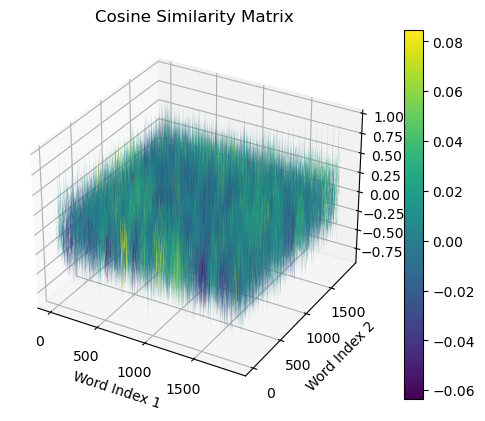

In [ ]:
# Assuming `sim_matrix` is already loaded or computed
x = np.arange(0, sim_matrix.shape[0], 1)
y = np.arange(0, sim_matrix.shape[1], 1)
X, Y = np.meshgrid(x, y)  # Create a mesh grid for x, y coordinates
Z = sim_matrix  # The similarity values become the z-coordinates

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Create a 3D plotting axis

# Plot a surface
surface = ax.plot_surface(X, Y, Z, cmap='viridis')  # Use a color map of your choice

# Add labels and title
ax.set_xlabel('Word Index 1')
ax.set_ylabel('Word Index 2')
ax.set_zlabel('Cosine Similarity')
ax.set_title('Cosine Similarity Matrix')

# Add a color bar to show the similarity scale
fig.colorbar(surface)

# Show the plot
plt.show()

3 3


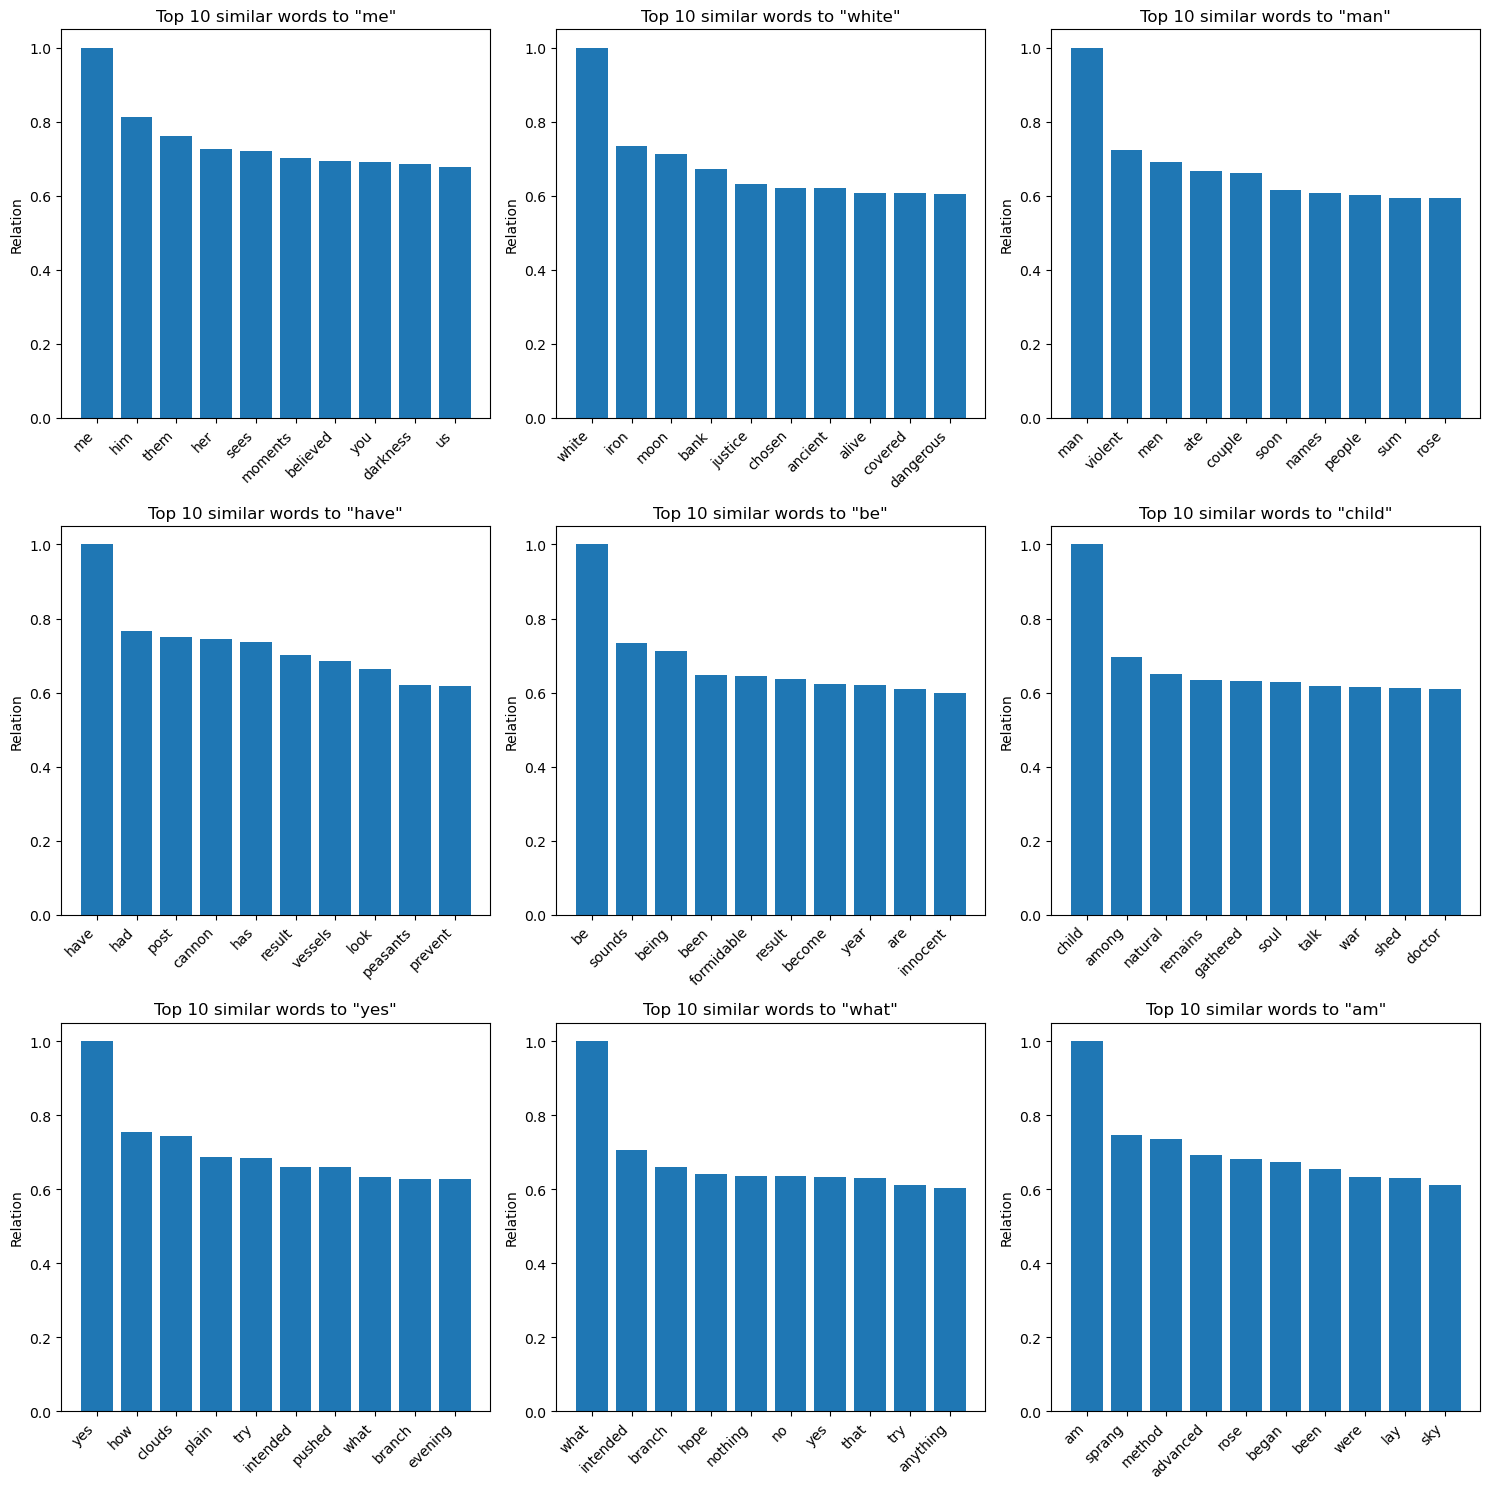

In [ ]:
testing_words = ["me", "white", "man", "have", "be", "child", "yes", "what", 'am']
vocab_stoi = vocab.get_stoi()
testing_words_idx = [(i, vocab.get_stoi()[i]) for i in testing_words]


sim_words_dict =  []
n_most_similar = 10
for i,w in enumerate(testing_words_idx):

    indices = (-sim_matrix[w[1]]).argsort()[:n_most_similar]
    sim_words = [(vocab_itos[i], sim_matrix[w[1]][i]) for i in indices]

    x_words = []
    y_relate = []

    for word, relate in sim_words:
        x_words.append(word)
        y_relate.append(relate)

    sim_words_dict.append((w[0], x_words, y_relate))

n_plots = len(testing_words)
n_cols = 3
n_rows = (len(testing_words) + n_cols - 1) // n_cols  # Calculate needed rows, round up
print(n_rows, n_cols)
# Initialise the subplot function using number of rows and columns 
figure, axis = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows)) 
  
# Plotting each set of similar words
i=0
for row in range(n_rows):
    for col in range(n_cols):
        if i < n_plots:
            word, related_words, related_ratio = sim_words_dict[row*n_cols + col]
            axis[row,col].bar(related_words, related_ratio)
            axis[row,col].set_title(f'Top {n_most_similar} similar words to "{word}"') 
            axis[row,col].set_xticks(range(len(related_words)))
            axis[row,col].set_xticklabels(related_words, rotation=45, ha='right')
            axis[row,col].set_ylabel('Relation')
            i += 1
        
plt.tight_layout()
plt.show()

## 2.1.6. Visualize the embedding space

In [ ]:
import csv

with open(PATH_GENERATED +"./weights.tsv", "wt") as out_file:
    tsv_writer = csv.writer(out_file, delimiter="\t")
    for i in best_embedding_weights:
        tsv_writer.writerow(i.numpy())


with open(PATH_GENERATED +"./metadata.tsv", "wt") as out_file:
    tsv_writer = csv.writer(out_file, delimiter="\t")
    for i in vocab_itos:
        tsv_writer.writerow([i])



Update them

![Captura desde 2024-04-23 01-39-41.png](<attachment:Captura desde 2024-04-23 01-39-41.png>)

![Captura desde 2024-04-23 01-38-52.png](<attachment:Captura desde 2024-04-23 01-38-52.png>)
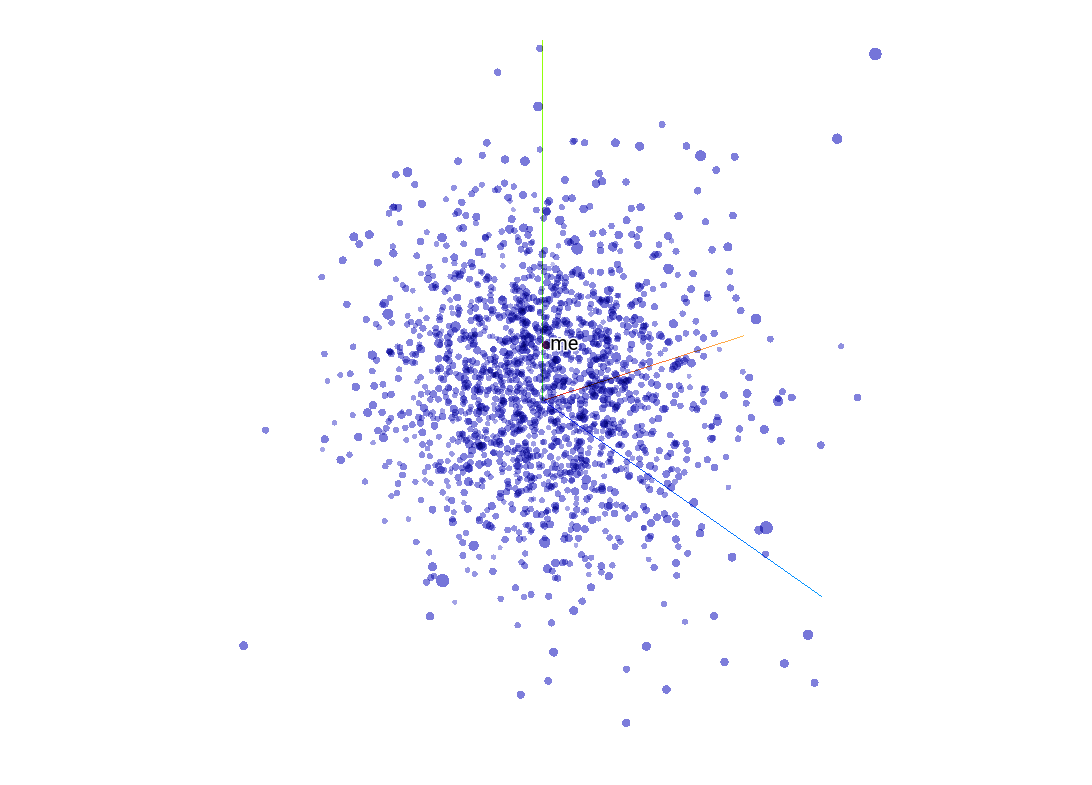
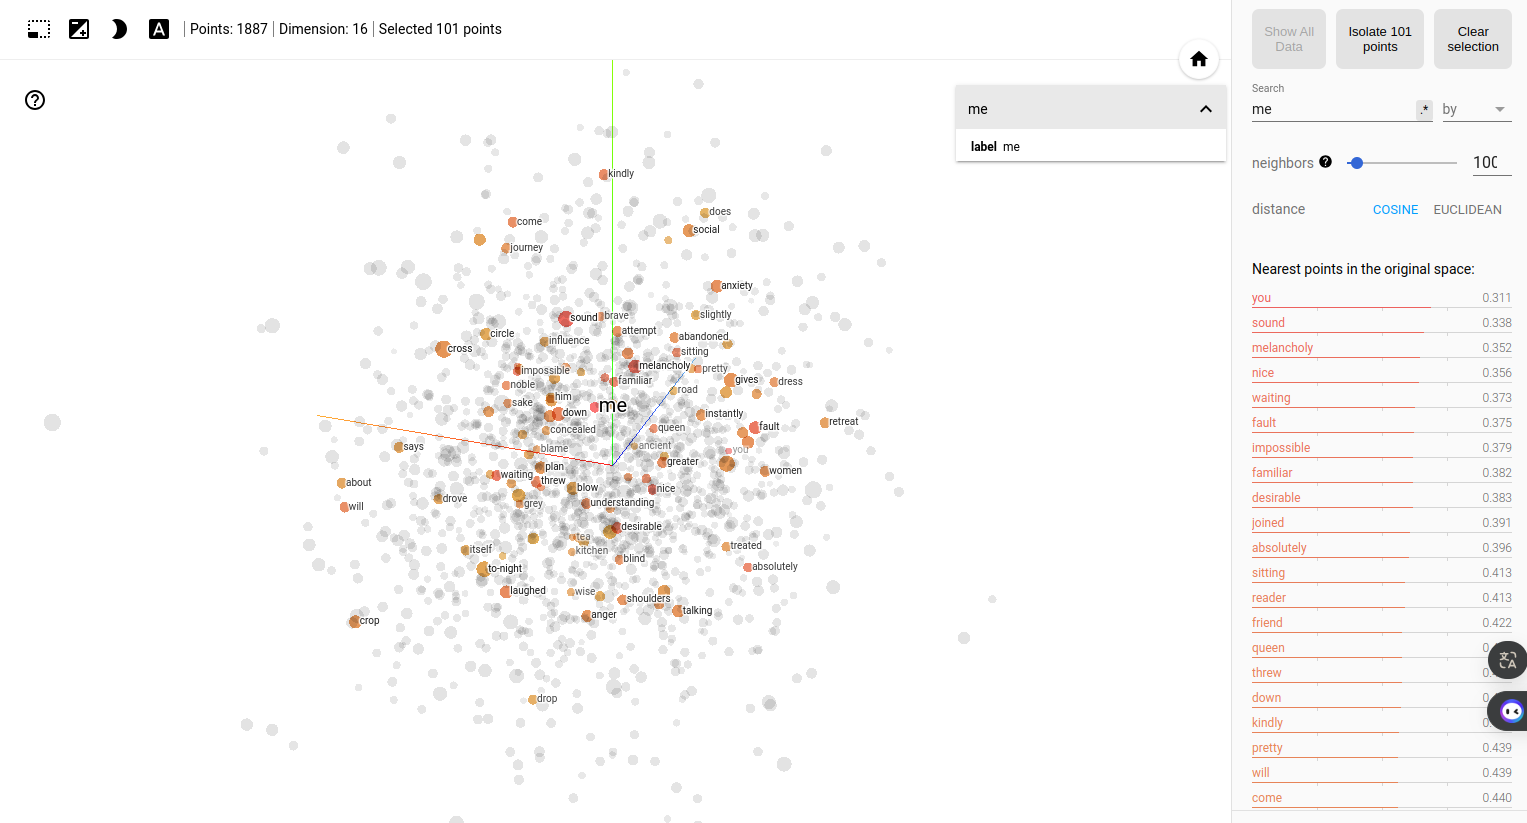

_______________________________
# 2.2 Conjugating be and have:

#### Setting Up the vocab for conjugation

For this part we would first need to make the 12 first words in our vocab be the possible conjugations as the neuronal netowrk will give a value from 0-11. This is important as we want the Target words to be the first ones in the vocab. This will be useful as we will be able to convert the output of the model to the word easily

In [ ]:

TARGET_OUTPUT = ["be", "am", "are", "is", "was", "were", "been", "being", "have", "has", "had", "having"]
print("Possible words prediction: ", len(TARGET_OUTPUT),", ", TARGET_OUTPUT)


# ----------------------- Create vocabulary ----------------------------
VOCAB_CONJUGATE_FNAME = PATH_GENERATED + PATH_WORDS + "vocabulary_conjugate.pt"
# Load vocabulary if you have already generated it
# Otherwise, create it and save it
if os.path.isfile(VOCAB_CONJUGATE_FNAME):
    vocab_conjugate = torch.load(VOCAB_CONJUGATE_FNAME)
else:
    # Get lists of strings, one for each line in each .txt files in 'datapath' 
    lines_books_train = read_files('./data_train/')

    # Create vocabulary based on the words in the training dataset
    t_output = list(TARGET_OUTPUT)
    t_output.append('<unk>')
    vocab_conjugate = create_vocabulary(lines_books_train, min_freq=MIN_FREQ, specials=t_output)
    torch.save(vocab_conjugate, VOCAB_CONJUGATE_FNAME)

print("Lenght of the vocab: ", len(vocab_conjugate))
vocab_conjugate_dict = vocab_conjugate.get_itos()

target_to_idx = {target: i for i, target in enumerate(TARGET_OUTPUT)}

# Dict to get the index of each word
target_to_idx = {}

# Search for the word and get the index
print("Index in vocab of the target words:")
for i, palabra in enumerate(TARGET_OUTPUT):
    try:
        indice = vocab_conjugate_dict.index(palabra)
        target_to_idx[palabra] = indice
        print(f"{i}: '{palabra}' has the index {indice}.")
    except ValueError:
        print(f"The word:'{palabra}' was not found.")
        target_to_idx[palabra] = None


     

Possible words prediction:  12 ,  ['be', 'am', 'are', 'is', 'was', 'were', 'been', 'being', 'have', 'has', 'had', 'having']
Lenght of the vocab:  1875
Index in vocab of the target words:
0: 'be' has the index 0.
1: 'am' has the index 1.
2: 'are' has the index 2.
3: 'is' has the index 3.
4: 'was' has the index 4.
5: 'were' has the index 5.
6: 'been' has the index 6.
7: 'being' has the index 7.
8: 'have' has the index 8.
9: 'has' has the index 9.
10: 'had' has the index 10.
11: 'having' has the index 11.


#### Show the frequency of the target words

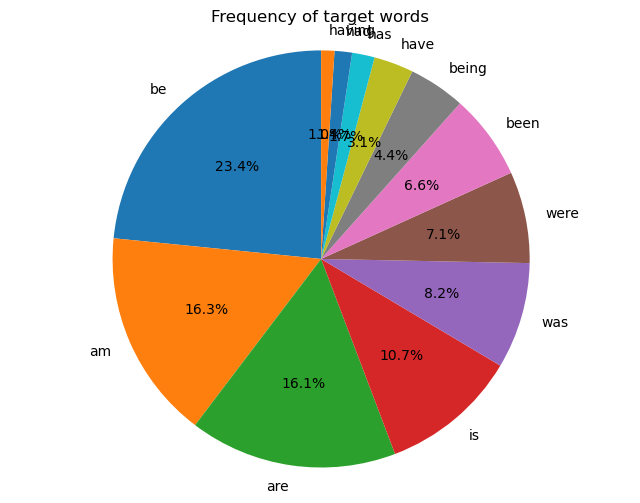

In [ ]:
occurrences_targetWords_freq = [freq for freq, word in occurrences if word in TARGET_OUTPUT]

# Etiquetas para el gráfico, que son nuestras palabras objetivo

# Verificar que el tamaño total no es cero para evitar errores de división por cero en gráficos vacíos
if sum(occurrences_targetWords_freq) > 0:
    plt.figure(figsize=(8, 6))
    plt.pie(occurrences_targetWords_freq, labels=TARGET_OUTPUT, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Esto asegura que el gráfico de pastel sea un círculo
    plt.title('Frequency of target words')
    plt.show()
else:
    print("Target words are not in the text")

For each conjugation of be and have we will show the most common preciding and following words

Studyng the word be most common preceding and following words


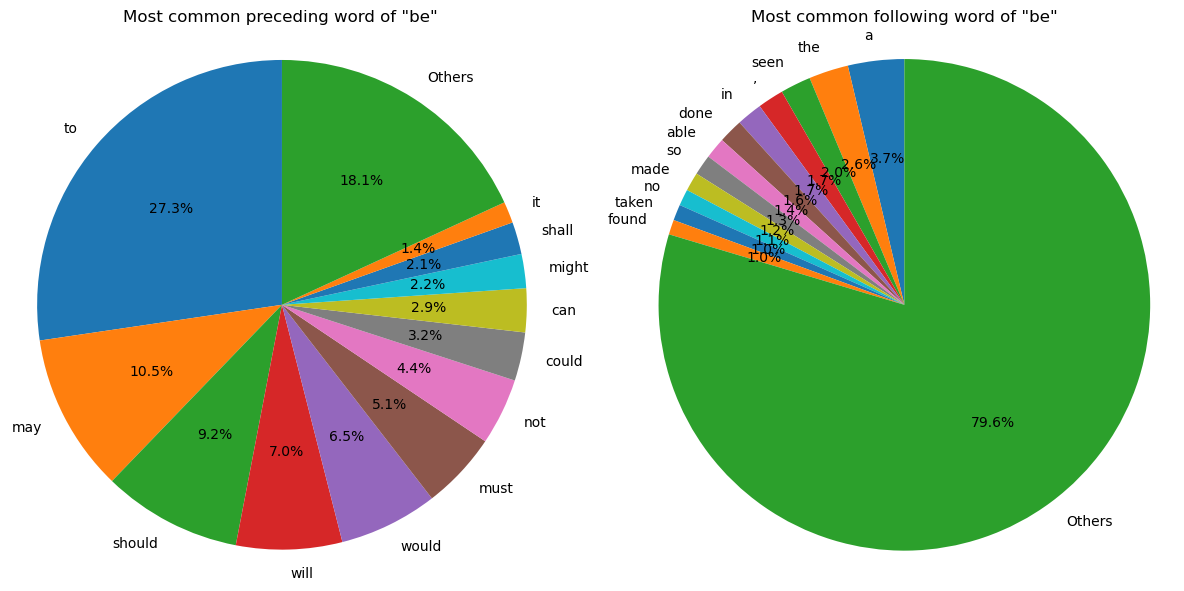

Studyng the word am most common preceding and following words


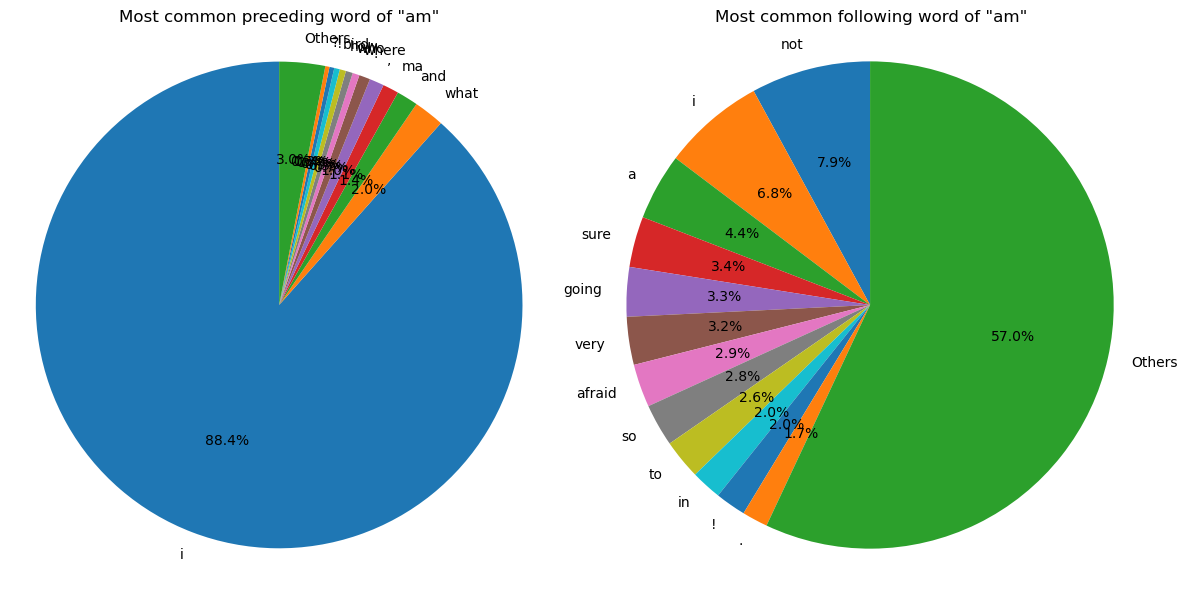

Studyng the word are most common preceding and following words


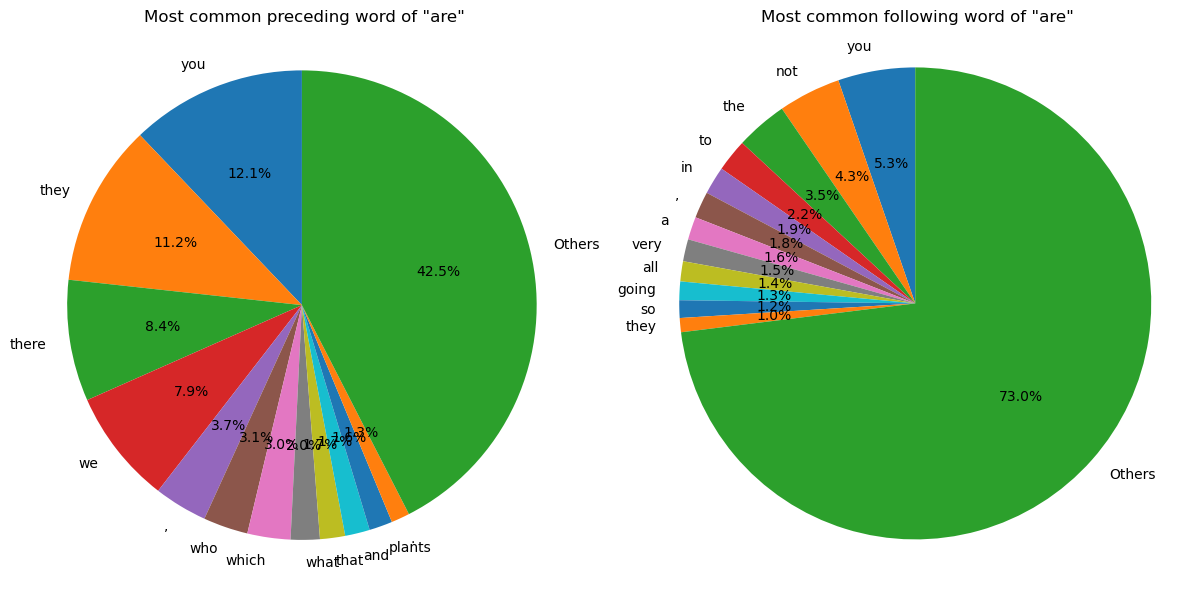

Studyng the word is most common preceding and following words


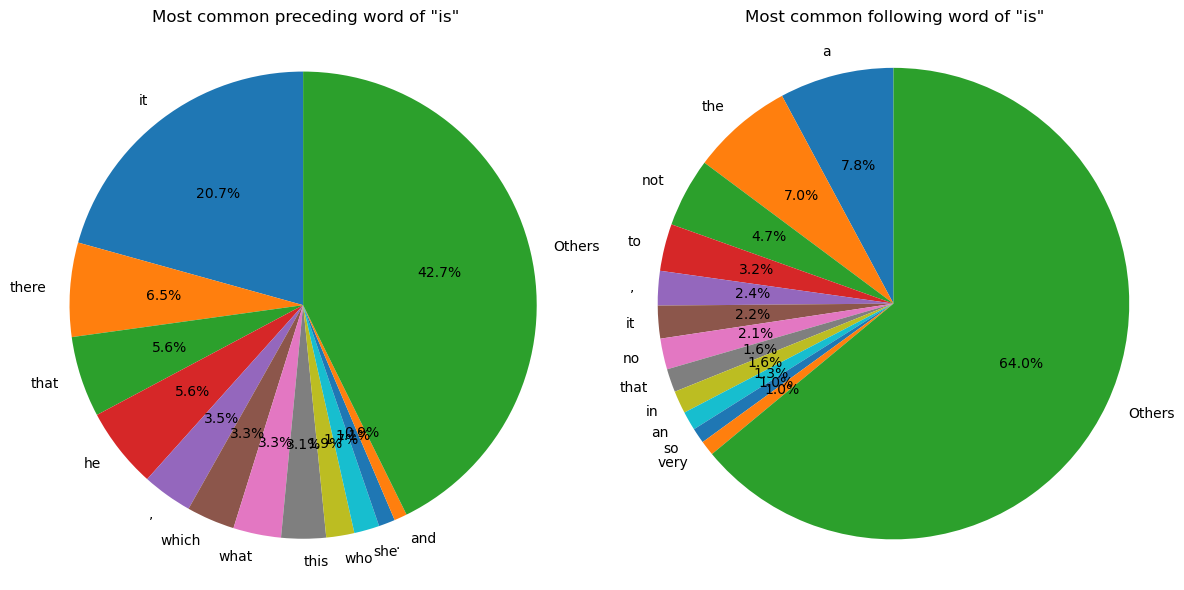

Studyng the word was most common preceding and following words


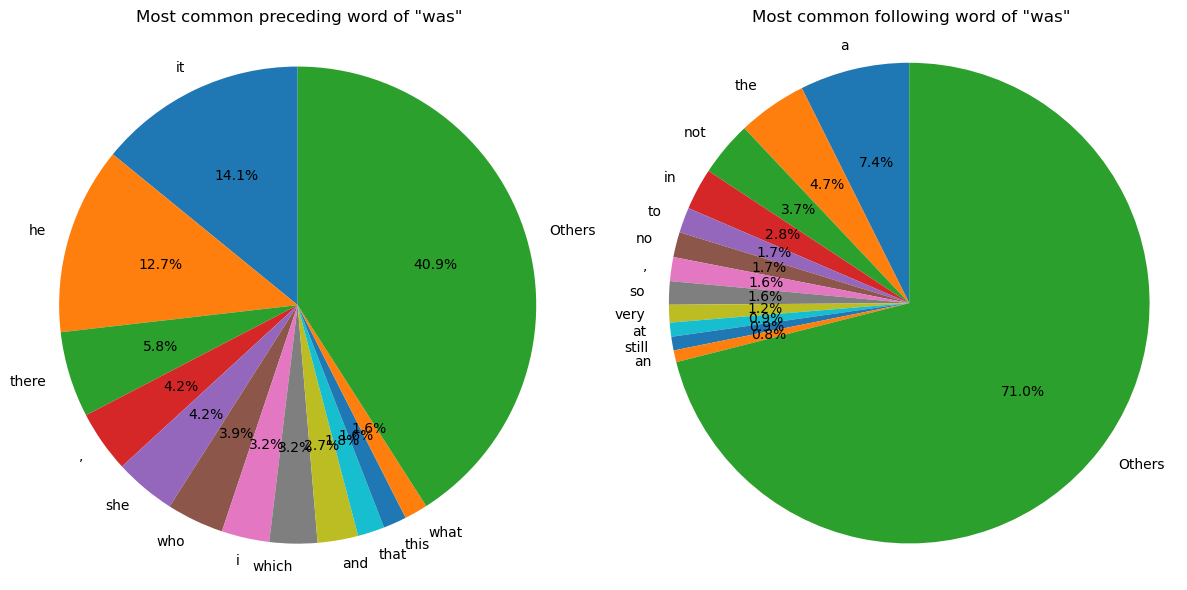

Studyng the word were most common preceding and following words


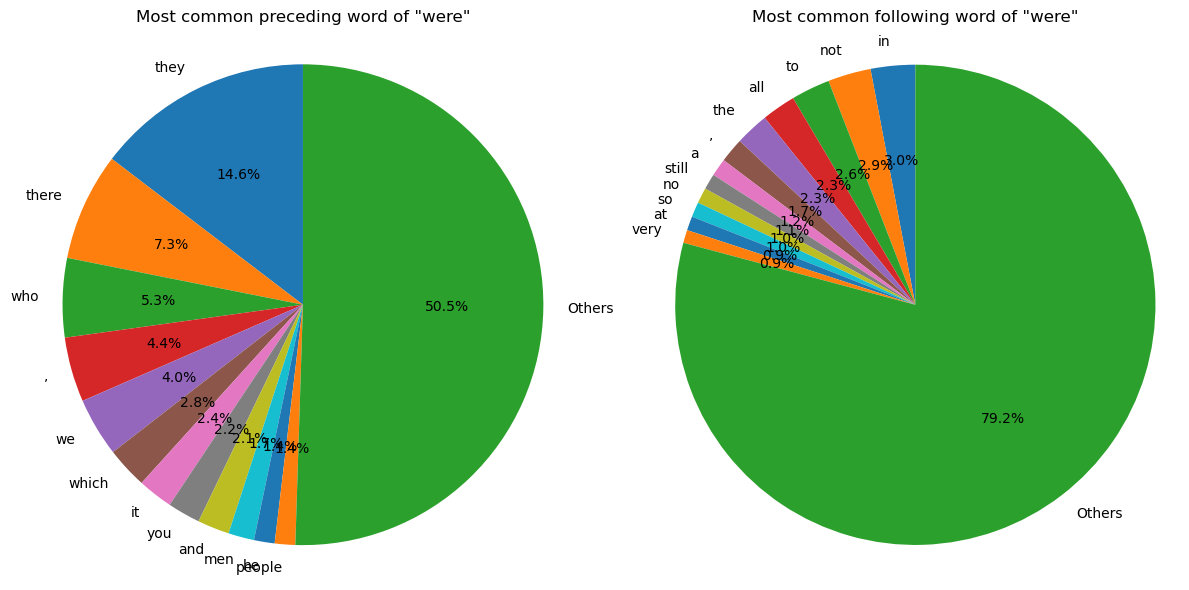

Studyng the word been most common preceding and following words


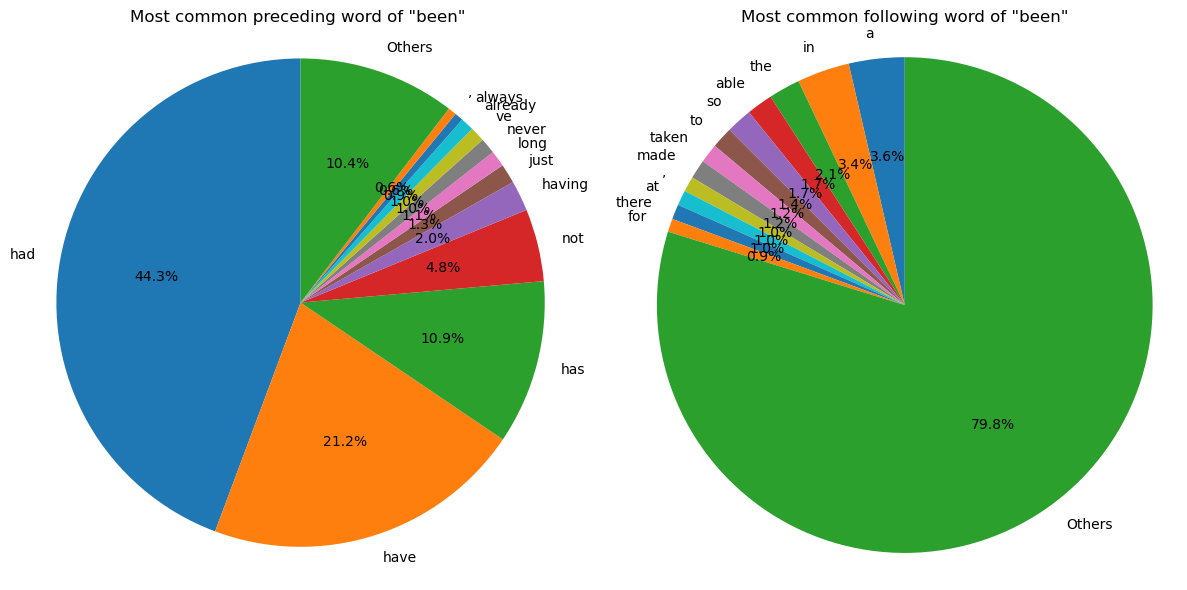

Studyng the word being most common preceding and following words


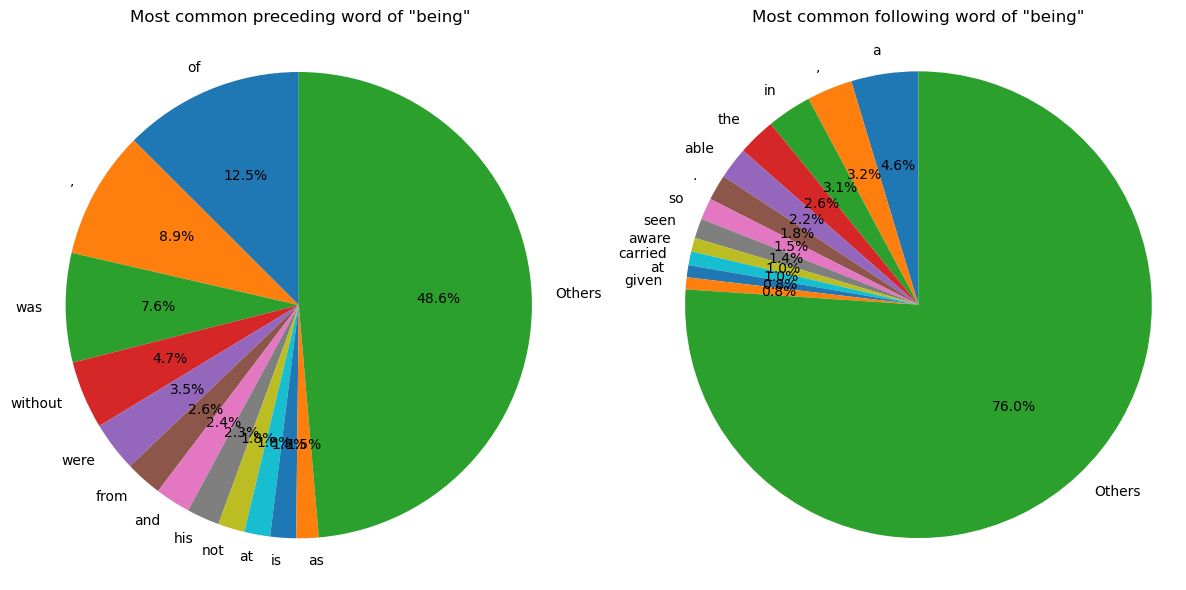

Studyng the word have most common preceding and following words


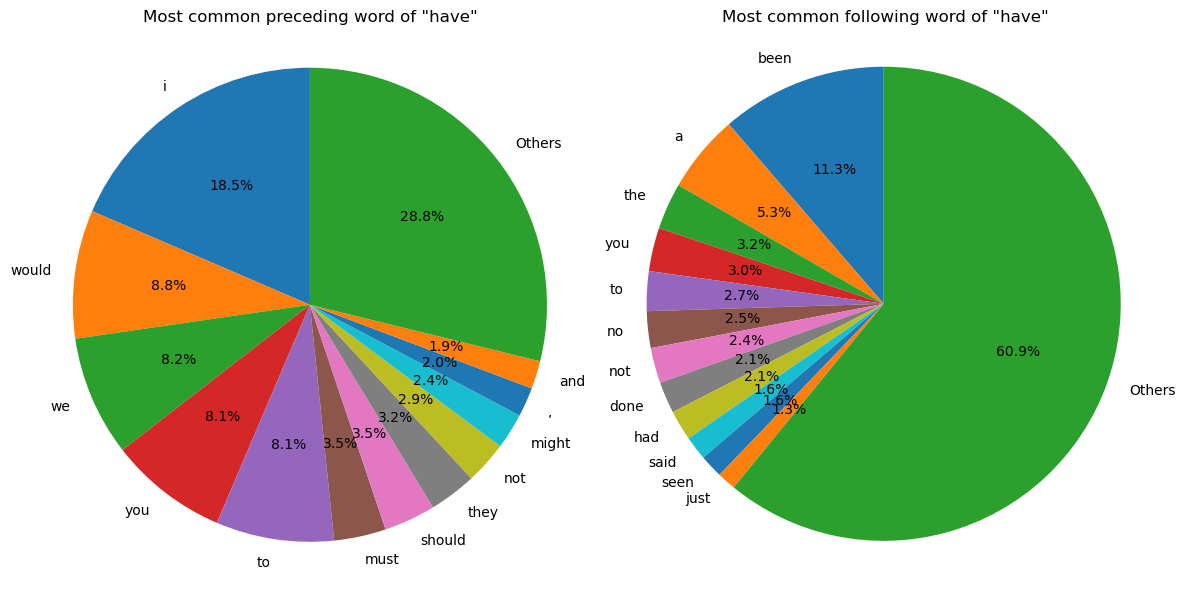

Studyng the word has most common preceding and following words


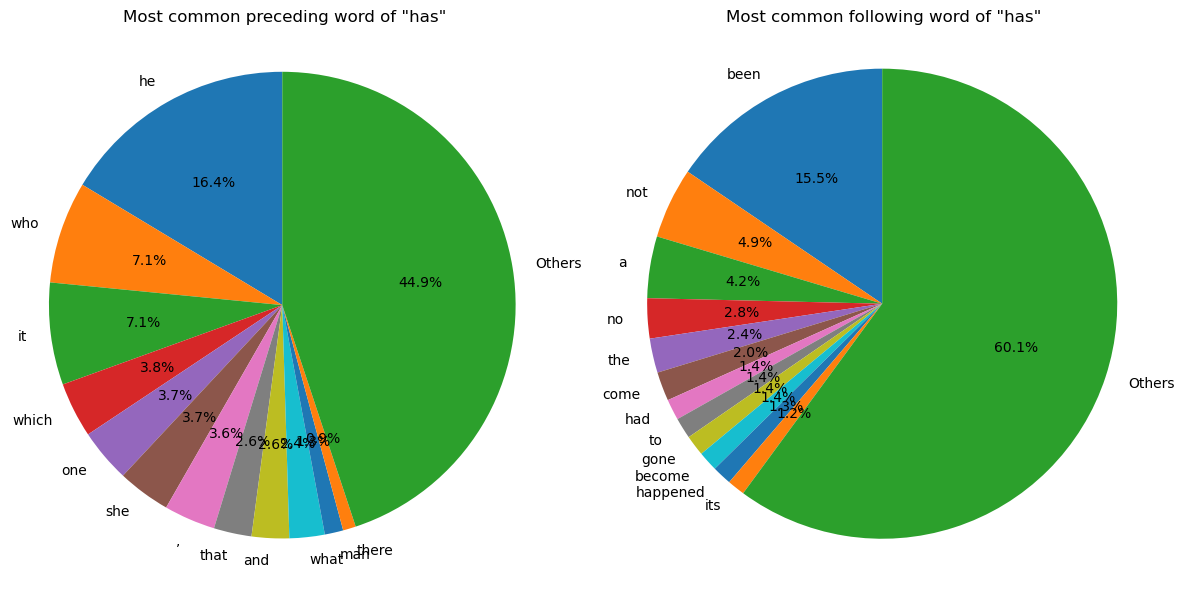

Studyng the word had most common preceding and following words


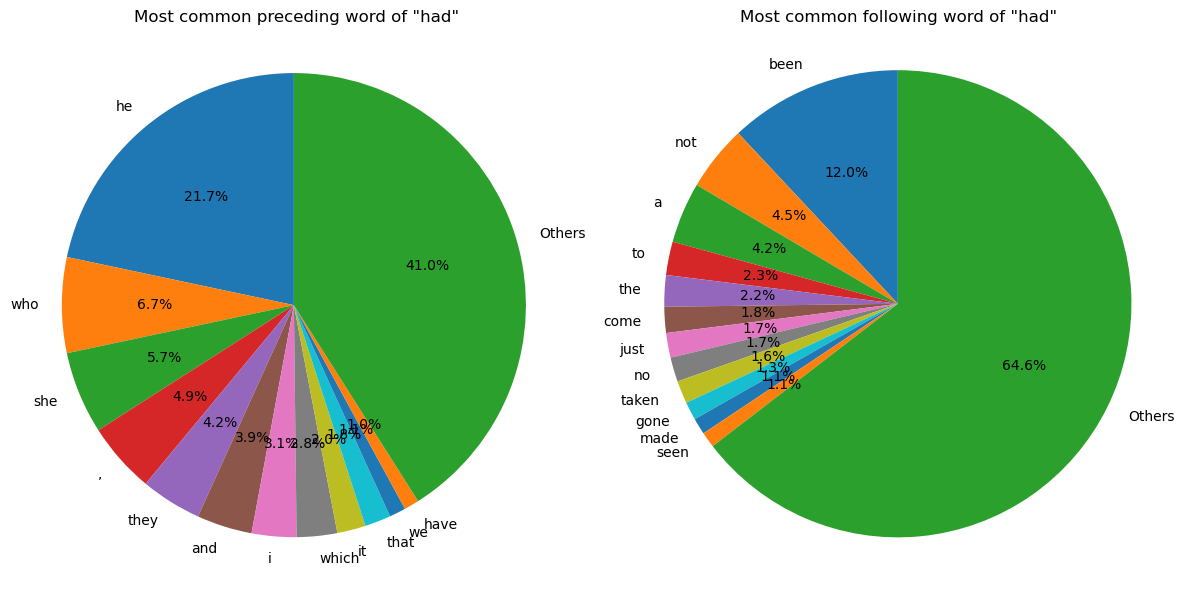

Studyng the word having most common preceding and following words


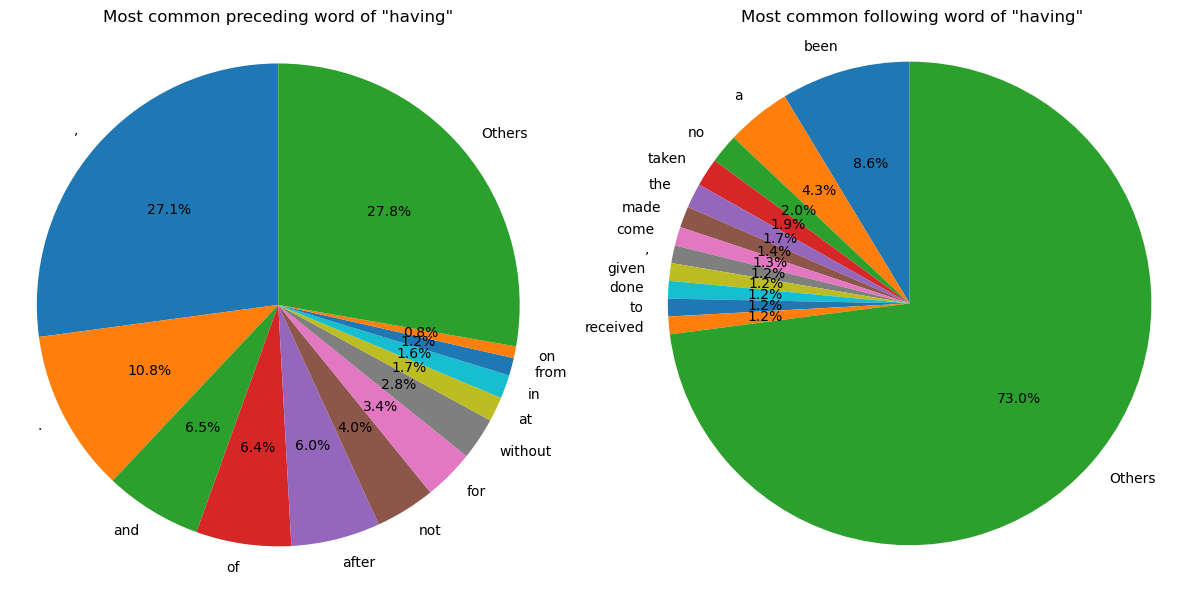

In [ ]:
def find_preceding_words(words, word_list):
    import re
    from collections import defaultdict, Counter
    
    # Diccionario para mantener contadores separados para cada palabra objetivo
    preceding_words = defaultdict(Counter)
    
    # Buscar cada palabra en la lista y registrar la palabra que la precede
    for i in range(1, len(words)):
        if words[i] in word_list:
            preceding_words[words[i]][words[i-1]] += 1
    
    # Convertir cada contador en una lista de las palabras más comunes y sus conteos
    most_common_preceding = {word: counter.most_common() for word, counter in preceding_words.items()}
    return most_common_preceding

preceding_words_TargetOutput = find_preceding_words(words_train, TARGET_OUTPUT)

def find_following_words(words, word_list):
    import re
    from collections import defaultdict, Counter
    
    # Diccionario para mantener contadores separados para cada palabra objetivo
    following_words = defaultdict(Counter)
    
    # Buscar cada palabra en la lista y registrar la palabra que la precede
    for i in range(0, len(words)-1):
        if words[i] in word_list:
            following_words[words[i]][words[i+1]] += 1
    
    # Convertir cada contador en una lista de las palabras más comunes y sus conteos
    most_common_following = {word: counter.most_common() for word, counter in following_words.items()}
    return most_common_following

preceding_words_TargetOutput = find_preceding_words(words_train, TARGET_OUTPUT)    
following_words_TargetOutput = find_following_words(words_train, TARGET_OUTPUT)


for target_word in TARGET_OUTPUT:
    print(f"Studyng the word {target_word} most common preceding and following words")
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots
    
    # Process data for preceding words
    data_preceding = preceding_words_TargetOutput[target_word]
    if len(data_preceding) > 12:
        top_data_preceding = data_preceding[:12]
        others_count_preceding = sum([item[1] for item in data_preceding[12:]])
        top_data_preceding.append(('Others', others_count_preceding))
    else:
        top_data_preceding = data_preceding

    labels_preceding = [item[0] for item in top_data_preceding]
    sizes_preceding = [item[1] for item in top_data_preceding]

    # Pie chart for preceding words
    ax[0].pie(sizes_preceding, labels=labels_preceding, autopct='%1.1f%%', startangle=90)
    ax[0].set_title(f'Most common preceding word of "{target_word}"')
    ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Process data for following words
    data_following = following_words_TargetOutput[target_word]
    if len(data_following) > 12:
        top_data_following = data_following[:12]
        others_count_following = sum([item[1] for item in data_following[12:]])
        top_data_following.append(('Others', others_count_following))
    else:
        top_data_following = data_following

    labels_following = [item[0] for item in top_data_following]
    sizes_following = [item[1] for item in top_data_following]

    # Pie chart for following words
    ax[1].pie(sizes_following, labels=labels_following, autopct='%1.1f%%', startangle=90)
    ax[1].set_title(f'Most common following word of "{target_word}"')
    ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()  # Automatically adjust subplots to fit the figure
    plt.show()


## 2.2.1 MLP and RNN prediction of be and have conjugation given the context around the target


#### Dataset preparation

Prepare the dataset with a set of words around the context. We did 2 configurations, using 5 words before 5 after and another one using 12 words before 6 after. This 2 configurations were made to see if the models work better with more context or if it would cause overfitting. 

In [ ]:
batch_size = 256
print(f"Batch size: {batch_size}")

print()
before_context_size= 12; after_context_size=6
train_conjugate_data_12_6 = load_dataset(words_train, vocab_conjugate, f"data_train_{before_context_size}_{after_context_size}.pt", before_context_size, after_context_size, TARGET_OUTPUT, target_to_idx)
val_conjugate_data_12_6 = load_dataset(words_val, vocab_conjugate, f"data_val_{before_context_size}_{after_context_size}.pt", before_context_size, after_context_size, TARGET_OUTPUT, target_to_idx)
test_conjugate_data_12_6 = load_dataset(words_test, vocab_conjugate, f"data_test_{before_context_size}_{after_context_size}.pt", before_context_size, after_context_size, TARGET_OUTPUT, target_to_idx)

train_conjugate_data_loader_12_6 = DataLoader(train_conjugate_data_12_6, batch_size=batch_size, shuffle=True)
val_conjugate_data_loader_12_6 = DataLoader(val_conjugate_data_12_6, batch_size=batch_size, shuffle=True)
test_conjugate_data_loader_12_6 = DataLoader(test_conjugate_data_12_6, batch_size=batch_size, shuffle=True)

print(f"-{before_context_size} words before {after_context_size} after configuration: ")
print("Total number of entries in the training dataLoader:   ", len(train_conjugate_data_loader_12_6))
print("Total number of entries in the validation dataLoader: ", len(val_conjugate_data_loader_12_6))
print("Total number of entries in the test dataLoader:       ", len(test_conjugate_data_loader_12_6))

max_index = max([max(batch[0].flatten()) for batch, _ in train_conjugate_data_loader_12_6])  # Assuming contexts are in batch[0]
assert max_index < len(vocab_conjugate), f"Vocab size {len(vocab_conjugate)} is too small for max index {max_index}"

print()
# Creating Tensors for 5 words before and 5 after the target
before_context_size= 5; after_context_size=5
train_conjugate_data_5_5 = load_dataset(words_train, vocab_conjugate, f"data_conjugate_train_{before_context_size}_{after_context_size}.pt", before_context_size, after_context_size, TARGET_OUTPUT, target_to_idx)
val_conjugate_data_5_5 = load_dataset(words_val, vocab_conjugate, f"data_conjugate_val_{before_context_size}_{after_context_size}.pt", before_context_size, after_context_size, TARGET_OUTPUT, target_to_idx)
test_conjugate_data_5_5 = load_dataset(words_test, vocab_conjugate, f"data_conjugate_test_{before_context_size}_{after_context_size}.pt", before_context_size, after_context_size, TARGET_OUTPUT, target_to_idx)

train_conjugate_data_loader_5_5 = DataLoader(train_conjugate_data_5_5, batch_size=batch_size, shuffle=True)
val_conjugate_data_loader_5_5 = DataLoader(val_conjugate_data_5_5, batch_size=batch_size, shuffle=True)
test_conjugate_data_loader_5_5 = DataLoader(test_conjugate_data_5_5, batch_size=batch_size, shuffle=True)

print(f"-{before_context_size} words before {after_context_size} after configuration: ")
print("Total number of entries in the training dataLoader:   ", len(train_conjugate_data_loader_5_5))
print("Total number of entries in the validation dataLoader: ", len(val_conjugate_data_loader_5_5))
print("Total number of entries in the test dataLoader:       ", len(test_conjugate_data_loader_5_5))

max_index = max([max(batch[0].flatten()) for batch, _ in train_conjugate_data_loader_5_5])  # Assuming contexts are in batch[0]
assert max_index < len(vocab_conjugate), f"Vocab size {len(vocab_conjugate)} is too small for max index {max_index}"


Batch size: 256

data_train_12_6.pt loaded from saved files.
data_val_12_6.pt loaded from saved files.
data_test_12_6.pt loaded from saved files.
-12 words before 6 after configuration: 
Total number of entries in the training dataLoader:    485
Total number of entries in the validation dataLoader:  11
Total number of entries in the test dataLoader:        19

data_conjugate_train_5_5.pt loaded from saved files.
data_conjugate_val_5_5.pt loaded from saved files.
data_conjugate_test_5_5.pt loaded from saved files.
-5 words before 5 after configuration: 
Total number of entries in the training dataLoader:    485
Total number of entries in the validation dataLoader:  11
Total number of entries in the test dataLoader:        19


Check the train data.

In [ ]:
index = (200, 205)
print("************** Tensors-> 12 Words before, 6 after examples: **************")
showDataSet(train_conjugate_data_12_6, vocab_conjugate_dict, index, 12, 6)

print("\n************** Tensors-> 5 Words before, 5 after examples: **************")
showDataSet(train_conjugate_data_5_5, vocab_conjugate_dict, index, 5, 5)

************** Tensors-> 12 Words before, 6 after examples: **************
 Input:  [12, 33, 12, 718, 13, 826, 12, 15, 12, 12, 12, 14, 1708, 77, 12, 20, 4, 12]  Target:  7 -> { being }
   -> { <unk> which <unk> formed the real <unk> of <unk> <unk> <unk> and  *being* convinced himself <unk> he was <unk> }
 Input:  [826, 12, 15, 12, 12, 12, 14, 7, 1708, 77, 12, 20, 12, 12, 12, 12, 12, 16]  Target:  4 -> { was }
   -> { real <unk> of <unk> <unk> <unk> and being convinced himself <unk> he  *was* <unk> <unk> <unk> <unk> <unk> to }
 Input:  [12, 20, 4, 12, 12, 12, 12, 12, 16, 230, 21, 616, 1612, 14, 12, 12, 20, 189]  Target:  4 -> { was }
   -> { <unk> he was <unk> <unk> <unk> <unk> <unk> to words his conversation  *was* gay and <unk> <unk> he put }
 Input:  [20, 189, 77, 26, 17, 1512, 23, 13, 83, 92, 493, 43, 262, 55, 1073, 447, 27, 12]  Target:  10 -> { had }
   -> { he put himself on a level with the two old women who  *had* passed their lives beside him <unk> }
 Input:  [10, 262, 55, 107

## Create the models

#### MLP model

First simple MLP model

In [ ]:
# Define the MLP model with appropriate output dimension for 12 classes
class MLPModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, before_context_size, after_context_size, pretrained_embeddings):
        super(MLPModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Load the pretrained embeddings
        self.embedding.weight = nn.Parameter(pretrained_embeddings, requires_grad=False)

        self.fc1 = nn.Linear(embedding_dim * (before_context_size + after_context_size), 256)
        self.fc2 = nn.Linear(256, output_dim)  # Output dimension is 12 for 12 forms of 'be' and 'have'

    def forward(self, x):
        x = self.embedding(x).view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


MLP model with an Attention layer

In [ ]:
class MLPAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, before_context_size, after_context_size, pretrained_embeddings):
        super(MLPAttentionModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Load the pretrained embeddings
        self.embedding.weight = nn.Parameter(pretrained_embeddings, requires_grad=False)    

        self.attention = nn.MultiheadAttention(embedding_dim, num_heads=16, batch_first=True)
        self.fc1 = nn.Linear(embedding_dim * ( before_context_size + after_context_size), 256)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.attention(x, x, x)
        x = x.reshape(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### RNN models

First RNN model.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pretrained_embeddings):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Load the pretrained embeddings
        self.embedding.weight = nn.Parameter(pretrained_embeddings, requires_grad=False)

        self.rnn = nn.LSTM(embedding_dim, 256, batch_first=True)
        self.fc = nn.Linear(256, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        output, (hidden, cell) = self.rnn(x)
        last_hidden = output[:, -1, :]
        last_hidden = torch.relu(last_hidden)  # Applying ReLU for non-linearity, lets see how it works
        out = self.fc(last_hidden)
        return out

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            output = self.forward(x)
            _, predicted_index = torch.max(output, 1)
        return predicted_index

Second RNN Model more complex. 

In [ ]:
class RNNModelComplex(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pretrained_embeddings):
        super(RNNModelComplex, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Load the pretrained embeddings
        self.embedding.weight = nn.Parameter(pretrained_embeddings)
        self.embedding.weight.requires_grad = False  # Change to True if fine-tuning is beneficial

        self.rnn = nn.LSTM(embedding_dim, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
        self.fc1 = nn.Linear(256 * 2, 256)  # Adjust for bidirectional output
        self.batch_norm = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        output, (hidden, cell) = self.rnn(x)
        last_hidden = output[:, -1, :]
        
        # Applying additional layers and normalization
        last_hidden = F.relu(self.fc1(last_hidden))
        last_hidden = self.batch_norm(last_hidden)
        out = self.fc2(last_hidden)
        
        return out

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            output = self.forward(x)
            _, predicted_index = torch.max(output, 1)
        return predicted_index


In [ ]:
class RNNModelNoWeights(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, 100, batch_first=True)
        self.fc = nn.Linear(100, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        output, (hidden, cell) = self.rnn(x)
        last_hidden = output[:, -1, :]
        out = self.fc(last_hidden)
        return out

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            output = self.forward(x)
            _, predicted_index = torch.max(output, 1)
        return predicted_index


## 2.2.2. Train models and evaluate performance


#### Train the RNN models

trained with 16 words context before and 4 words context after

In [ ]:
models_5_5 = [] # Models trained with 5 words before and 5 after
models_5_5_titles = [] # Titles

models_12_6 = [] # Models trained with 12 words before 6 after
models_12_6_titles = [] # Titles

model_counter=1

In [ ]:
model_counter=1

def addToModelList(model, modelTitle, train_loader_title):

    if train_loader_title == "Before=5,After=5":
        if modelTitle not in models_5_5_titles: # Dont add again if it is already there
            models_5_5.append(model)
            models_5_5_titles.append(modelTitle)

    elif train_loader_title == "Before=12,After=6":
        if modelTitle not in models_12_6_titles: # Dont add again if it is already there
            models_12_6.append(model)
            models_12_6_titles.append(modelTitle)

    global model_counter
    model_counter += 1
    

def train_all_models(embedding_dim, loaders, len_vocab, output_dim, pretrained_embeddings):

    loss_fn = nn.CrossEntropyLoss()
    global model_counter

    for i in range(len(loaders)):
        train_loader_title, train_loader, val_loader = loaders[i]

        # Separate the models for each the different DataLoaders
        if train_loader_title == "Before=5,After=5":
            before_context_size=5; after_context_size=5
        elif train_loader_title == "Before=12,After=6":
            before_context_size=12; after_context_size=6
            
        print("\n\nTraning the Dataloader: ", train_loader_title)


        print("********************************************  Training the MLP models ******************************************** ")
        modelTitle= "MLP_"+str(model_counter) +"_("+ train_loader_title+")" 
        file_path = PATH_GENERATED + PATH_MODELS + modelTitle + ".pt"
        print(f"\t{modelTitle}")
        if os.path.isfile(file_path): # If it has not been trained before
            model = torch.load(file_path)
        else:
            model =  MLPModel(len_vocab, embedding_dim, output_dim,  before_context_size, after_context_size, pretrained_embeddings)
            n_epochs = 30 # 3 seconds epoch
            learning_rate=0.001
            # 30 epochs 0.001 53% val
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
            train(n_epochs=n_epochs, optimizer=optimizer, scheduler=scheduler, model=model, loss_fn=loss_fn, train_loader=train_loader,val_loader=val_loader)
            torch.save(model, file_path)

        addToModelList(model, modelTitle, train_loader_title)

        modelTitle= "MLP_"+str(model_counter) +"_Attention_("+ train_loader_title+")" 
        file_path = PATH_GENERATED + PATH_MODELS + modelTitle + ".pt"
        print(f"\t{modelTitle}")
        if os.path.isfile(file_path): # If it has not been trained before
            model = torch.load(file_path)
        else:
            model =  MLPAttentionModel(len_vocab, embedding_dim, output_dim,  before_context_size, after_context_size, pretrained_embeddings)
            n_epochs = 30 # 3 seconds epoch
            learning_rate=0.001
            # 30 epochs 0.001 54% val
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.75)
            train(n_epochs=n_epochs, optimizer=optimizer, scheduler=scheduler, model=model, loss_fn=loss_fn, train_loader=train_loader,val_loader=val_loader)
            torch.save(model, file_path)

        addToModelList(model, modelTitle, train_loader_title)


        print("\n******************************************** Training the RNN models ******************************************** ")
        # RNN 1
        modelTitle= "RNN_"+str(model_counter) +"_("+ train_loader_title+")" 
        file_path = PATH_GENERATED + PATH_MODELS + modelTitle + ".pt"
        print(f"\t{modelTitle}")
        if os.path.isfile(file_path): # If it has not been trained before
            model = torch.load(file_path)
        else:
            model =  RNNModel(len_vocab, embedding_dim, output_dim, pretrained_embeddings)
            n_epochs = 30 # 30 seconds epoch
            learning_rate=0.001
            # Got 60% val max, changed the activation function, testing how it affects
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
            train(n_epochs=n_epochs, optimizer=optimizer, scheduler=scheduler, model=model, loss_fn=loss_fn, train_loader=train_loader,val_loader=val_loader)
            torch.save(model, file_path)

        addToModelList(model, modelTitle, train_loader_title)
        
        # RNN 2
        modelTitle= "RNN_"+str(model_counter) +"_Complex_("+ train_loader_title+")" 
        file_path = PATH_GENERATED + PATH_MODELS + modelTitle + ".pt"
        print(f"\t{modelTitle}")

        if os.path.isfile(file_path): # If it has not been trained before
            model = torch.load(file_path)
        else:
            model =  RNNModelComplex(len_vocab, embedding_dim, output_dim, pretrained_embeddings)
            n_epochs = 30 # 3:30 mins epoch
            learning_rate=0.001
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
            train(n_epochs=n_epochs, optimizer=optimizer, scheduler=scheduler, model=model, loss_fn=loss_fn, train_loader=train_loader,val_loader=val_loader)
            torch.save(model, file_path)

        addToModelList(model, modelTitle, train_loader_title)

        # RNN 3
        modelTitle= "RNN_"+str(model_counter) +"_NoWeights_("+ train_loader_title+")" 
        file_path = PATH_GENERATED + PATH_MODELS + modelTitle + ".pt"
        print(f"\t{modelTitle}")

        if os.path.isfile(file_path): # If it has not been trained before
            model = torch.load(file_path)
        else:
            model =  RNNModelNoWeights(len_vocab, embedding_dim, output_dim)
            n_epochs = 100 # 30 seconds epoch
            learning_rate=0.001
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
            train(n_epochs=n_epochs, optimizer=optimizer, scheduler=scheduler, model=model, loss_fn=loss_fn, train_loader=train_loader,val_loader=val_loader)
            torch.save(model, file_path)

        addToModelList(model, modelTitle, train_loader_title)

        
                


In [ ]:

# Minutes per epoch
# 3 seconds MLPModel
# 3 seconds MLPAttentionModel
# 30 minutes RNNModel 
# 3:30 minutes RNNModelComplex

embedding_dim = best_embedding_weights.size(1) # Use the embedding dimension of the best CBOW model
print("Using the embedding dimension of the best CBOW model: ", embedding_dim)


""" train_loaders = [("Before=5,After=5", train_conjugate_data_loader_5_5, val_conjugate_data_loader_5_5),
                ("Before=12,After=6",train_conjugate_data_loader_12_6, val_conjugate_data_loader_12_6)
                ] """

# I will first train the 5 before 5 after
train_loaders = [("Before=5,After=5", train_conjugate_data_loader_5_5, val_conjugate_data_loader_5_5)]

train_all_models(embedding_dim, train_loaders, len(vocab_conjugate), len(TARGET_OUTPUT),  best_embedding_weights)



Using the embedding dimension of the best CBOW model:  16


Traning the Dataloader:  Before=5,After=5
********************************************  Training the MLP models ******************************************** 
	MLP_1_(Before=5,After=5)
	MLP_2_Attention_(Before=5,After=5)

******************************************** Training the RNN models ******************************************** 
	RNN_3_(Before=5,After=5)
	RNN_4_Complex_(Before=5,After=5)


Demostration of the predictions

In [ ]:
# train_loaders=[(train_conjugate_data_loader_5_5,"Before=5,After=5") , (train_conjugate_data_loader_12_6, "Before=12,After=6")]
showPredictSamples(models_5_5, models_5_5_titles, vocab_conjugate_dict, train_conjugate_data_5_5, before_context_size=5, after_context_size=5,since=110, to=113)
showPredictSamples(models_12_6, models_12_6_titles, vocab_conjugate_dict, train_conjugate_data_12_6,before_context_size=12, after_context_size=6, since=110, to=113)



***************** Prediccting model:  MLP_1_(Before=5,After=5) *****************
CORRECT:   [Predicted Word: have,	Real Word: have]  	-> Phrase:  <unk> i tell you you *have* my house <unk> and i
CORRECT:   [Predicted Word: have,	Real Word: have]  	-> Phrase:  my house <unk> and i *have* yours <unk> give me back
CORRECT:   [Predicted Word: are,	Real Word: are]  	-> Phrase:  me back my house you *are* at home here <unk> on

***************** Prediccting model:  MLP_2_Attention_(Before=5,After=5) *****************
CORRECT:   [Predicted Word: have,	Real Word: have]  	-> Phrase:  <unk> i tell you you *have* my house <unk> and i
INCORRECT: [Predicted Word: am,	Real Word: have]  	-> Phrase:  my house <unk> and i *have* yours <unk> give me back
CORRECT:   [Predicted Word: are,	Real Word: are]  	-> Phrase:  me back my house you *are* at home here <unk> on

***************** Prediccting model:  RNN_3_(Before=5,After=5) *****************
INCORRECT: [Predicted Word: are,	Real Word: have]  	-> Phr

Here we can see better some examples of how the neural network is working for each model in each type of data

Selection of the best model

We now have to change a little bit how we meausre the performace as we have different approaches. For example we have an approach that will read 12 words before the target and 6 after and another approach that will instead read 5 before and 5 after. Each have different train/val/test DataLoaders, so we can not mix them.

In [ ]:
def accuracy(model, loader):
    """
    Compute the accuracy of model with given data loader
    """
    model.eval()
    correct = 0
    with torch.no_grad():
        for contexts, labels in loader:
            contexts = contexts.to(device=device)
            labels = labels.to(device=device)

            outputs = model(contexts)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    return correct / len(loader.dataset)

def accuracy_expanded(model, loader, target_words):
    """
    Gives detailed information for each word accuracy
    """
    model.eval()
    evaluation = []
    for _ in range(len(target_words)):
        evaluation.append([0, 0]) # Save the correct / total predictions
        
    with torch.no_grad():
        for contexts, labels in loader:
            contexts = contexts.to(device=device)
            labels = labels.to(device=device)

            for i in range(len(contexts)):
                context = contexts[i].unsqueeze(0)  # Agrega una dimensión de batch
                answer = labels[i].item()   
                with torch.no_grad():
                    output = model(context)
                    _, predicted_index = torch.max(output, 1)
                    predicted_index = predicted_index.item()  # Convierte el tensor a un entero Python
                evaluation[answer][0] += (predicted_index == answer) # Correct prediction, sum 1
                evaluation[answer][1] += 1 

    return evaluation

def model_selection_acc(models, titles, train_loader, val_loader):
    """
    Choose the best model from the list of models based on validation accuracy and returns the best accuracy 
    """
    best_model = None
    best_acc = 0
    for model, title in zip(models, titles):
        acc = accuracy(model, val_loader)
        train_acc = accuracy(model, train_loader)
        print(f"{title} | Train accuracy {train_acc:.2%} |  Validation accuracy {acc:.2%}")
        if acc > best_acc:
            best_model = model
            best_acc = acc
    return best_model, best_acc


def model_selection_multipleLoaders(data):
    best_model = None
    best_acc = 0
    best_loader = None

    for conjugation in data:
        title, models, titles, train_loader, val_loader, test_loader = conjugation
        print(f"Trying configuration: {title}")
        model, acc = model_selection_acc(models, titles, train_loader, val_loader)
        if acc > best_acc:
            best_model = model
            best_acc = acc
            best_loader = test_loader
    return best_model, best_loader




In [ ]:
def accuracy(model, loader):
    """
    Compute the accuracy of model with given data loader
    """
    model.eval()
    correct = 0
    with torch.no_grad():
        for contexts, labels in loader:
            contexts = contexts.to(device=device)
            labels = labels.to(device=device)

            outputs = model(contexts)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    return correct / len(loader.dataset)

def accuracy_expanded(model, loader, target_words):
    """
    Gives detailed information for each word accuracy
    """
    model.eval()
    evaluation = []
    for _ in range(len(target_words)):
        evaluation.append([0, 0]) # Save the correct / total predictions
        
    with torch.no_grad():
        for contexts, labels in loader:
            contexts = contexts.to(device=device)
            labels = labels.to(device=device)

            for i in range(len(contexts)):
                context = contexts[i].unsqueeze(0)  # Agrega una dimensión de batch
                answer = labels[i].item()   
                with torch.no_grad():
                    output = model(context)
                    _, predicted_index = torch.max(output, 1)
                    predicted_index = predicted_index.item()  # Convierte el tensor a un entero Python
                evaluation[answer][0] += (predicted_index == answer) # Correct prediction, sum 1
                evaluation[answer][1] += 1 

    return evaluation

def model_selection_acc(models, titles, train_loader, val_loader):
    """
    Choose the best model from the list of models based on validation accuracy and returns the best accuracy 
    """
    best_model = None
    best_acc = 0
    for model, title in zip(models, titles):
        acc = accuracy(model, val_loader)
        train_acc = accuracy(model, train_loader)
        print(f"{title} | Train accuracy {train_acc:.2%} |  Validation accuracy {acc:.2%}")
        if acc > best_acc:
            best_model = model
            best_acc = acc
    return best_model, best_acc


def model_selection_multipleLoaders(data):
    best_model = None
    best_acc = 0
    best_loader = None

    for conjugation in data:
        title, models, titles, train_loader, val_loader, test_loader = conjugation
        print(f"Trying configuration: {title}")
        model, acc = model_selection_acc(models, titles, train_loader, val_loader)
        if acc > best_acc:
            best_model = model
            best_acc = acc
            best_loader = test_loader
    return best_model, best_loader




In [ ]:

all_models_data=[
                    ['5 words before, 5 after', models_5_5, models_5_5_titles, train_conjugate_data_loader_5_5, val_conjugate_data_loader_5_5, test_conjugate_data_loader_5_5],
                    ['12 words before, 6 after', models_12_6, models_12_6_titles, train_conjugate_data_loader_12_6, val_conjugate_data_loader_12_6, test_conjugate_data_loader_12_6]
          ]



best_model, test_loader_conjugate = model_selection_multipleLoaders(all_models_data)

print(f"\nThe best model is: {best_model}")

best_model_acc = accuracy(best_model, test_loader_conjugate)
print(f"Best conjugating model | Test accuracy {best_model_acc:.2%}")


Trying configuration: 5 words before, 5 after
MLP_1_(Before=5,After=5) | Train accuracy 67.65% |  Validation accuracy 52.39%
MLP_2_Attention_(Before=5,After=5) | Train accuracy 66.84% |  Validation accuracy 53.82%
RNN_3_(Before=5,After=5) | Train accuracy 81.69% |  Validation accuracy 59.07%
RNN_4_Complex_(Before=5,After=5) | Train accuracy 99.66% |  Validation accuracy 56.33%
Trying configuration: 12 words before, 6 after

The best model is: RNNModel(
  (embedding): Embedding(1875, 16)
  (rnn): LSTM(16, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=12, bias=True)
)
Best conjugating model | Test accuracy 52.38%


Now based on the best model show the accuracy of each word

[[376, 437], [29, 62], [158, 346], [346, 640], [723, 1338], [110, 478], [159, 168], [22, 75], [230, 416], [19, 119], [297, 631], [27, 55]]


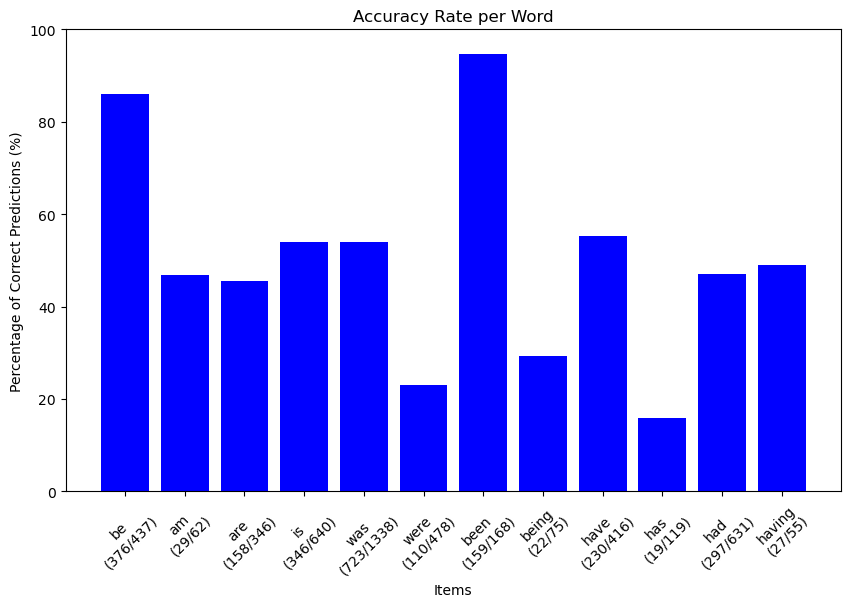

In [ ]:
expanded_accuracy = accuracy_expanded(best_model, test_loader_conjugate, TARGET_OUTPUT)
print(expanded_accuracy)

labels = []
for i,word in enumerate(TARGET_OUTPUT):
    correct, total = expanded_accuracy[i]
    if total != 0:
        labels.append(f"{word}\n({correct}/{total})")


percentages = [(correct / total) * 100 if total > 0 else 0 for correct, total in expanded_accuracy]

# Nombres de los elementos (opcional, puede ser simplemente índices)

plt.figure(figsize=(10, 6))  # Configura el tamaño de la figura
plt.bar(labels, percentages, color='blue')  # Crea un gráfico de barras
plt.xlabel('Items')
plt.ylabel('Percentage of Correct Predictions (%)')
plt.title('Accuracy Rate per Word')
plt.ylim(0, 100)  # Establece el límite del eje Y de 0 a 100%
plt.xticks(rotation=45)  # Rota las etiquetas del eje X para mejor visibilidad
plt.show()

Here we can apreciate the percentage of correct predictions for each name and the total amount of samples that were taken for each of them

_______________________________
# 2.3 Text generation:
Given the context before the target, predict the next word

Lets first start creating the contexts and targets for this models 

In [ ]:
batch_size = 256
print(f"Batch size: {batch_size}")

print()
before_context_size= 16; after_context_size=0
train_textGeneration_data = load_dataset(words_train, vocab, f"data_train_{before_context_size}_{after_context_size}.pt", before_context_size, after_context_size)
val_textGeneration_data = load_dataset(words_val, vocab, f"data_val_{before_context_size}_{after_context_size}.pt", before_context_size, after_context_size)
test_textGeneration_data = load_dataset(words_test, vocab, f"data_test_{before_context_size}_{after_context_size}.pt", before_context_size, after_context_size)

train_textGeneration_data_loader = DataLoader(train_textGeneration_data, batch_size=batch_size, shuffle=True)
val_textGeneration_data_loader = DataLoader(val_textGeneration_data, batch_size=batch_size, shuffle=True)
test_textGeneration_data_loader = DataLoader(test_textGeneration_data, batch_size=batch_size, shuffle=True)

print(f"-{before_context_size} words before {after_context_size} after configuration: ")
print("Total number of entries in the training dataLoader:   ", len(train_textGeneration_data_loader))
print("Total number of entries in the validation dataLoader: ", len(val_textGeneration_data_loader))
print("Total number of entries in the test dataLoader:       ", len(test_textGeneration_data_loader))

max_index = max([max(batch[0].flatten()) for batch, _ in train_textGeneration_data_loader])  # Assuming contexts are in batch[0]
assert max_index < len(vocab), f"Vocab size {len(vocab)} is too small for max index {max_index}"


Batch size: 256



data_train_16_0.pt loaded from saved files.
data_val_16_0.pt loaded from saved files.
data_test_16_0.pt loaded from saved files.
-16 words before 0 after configuration: 
Total number of entries in the training dataLoader:    7510
Total number of entries in the validation dataLoader:  142
Total number of entries in the test dataLoader:        328


## 2.3.1. Models

Model Rnn (same as for conjugating but now for all the possible words)

In [ ]:
modelsTxtGen = []
modelsTxtGen_counter = 1


## 2.3.2. Train models and evaluate performance


In [ ]:
embedding_dim = best_embedding_weights.size(1) # Use the embedding dimension of the best CBOW model
print("Using the embedding dimension of the best CBOW model: ", embedding_dim)

pretrained_embeddings = best_embedding_weights

print("\n******************************************** Training the RNN models ******************************************** ")
# RNN 1
modelTitle= "RNN_TxtGen_"+str(modelsTxtGen_counter)
file_path = PATH_GENERATED + PATH_MODELS + modelTitle + ".pt"
print(f"\t{modelTitle}")
if os.path.isfile(file_path): # If it has not been trained before
    model = torch.load(file_path)
else:
    model =  RNNModel(len(vocab), embedding_dim, len(vocab), pretrained_embeddings)
    n_epochs = 10 # 20 minutes epoch
    learning_rate=0.001
    # Got 60% val max, changed the activation function, testing how it affects
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    train(n_epochs=n_epochs, optimizer=optimizer, scheduler=scheduler, model=model, loss_fn=loss_fn, train_loader=train_textGeneration_data_loader,val_loader=val_textGeneration_data_loader)
    torch.save(model, file_path)

modelsTxtGen.append([modelTitle, model])

# RNN 2
modelsTxtGen_counter += 1
modelTitle= "RNN_TxtGen_"+str(modelsTxtGen_counter) +"_Complex"
file_path = PATH_GENERATED + PATH_MODELS + modelTitle + ".pt"
print(f"\t{modelTitle}")
if os.path.isfile(file_path): # If it has not been trained before
    model = torch.load(file_path)
else:
    model =  RNNModelComplex(len(vocab), embedding_dim, len(vocab), pretrained_embeddings)
    n_epochs = 10 # 2h 10 minutes epoch
    learning_rate=0.001
    # Got 60% val max, changed the activation function, testing how it affects
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    train(n_epochs=n_epochs, optimizer=optimizer, scheduler=scheduler, model=model, loss_fn=loss_fn, train_loader=train_textGeneration_data_loader,val_loader=val_textGeneration_data_loader)
    torch.save(model, file_path)

modelsTxtGen.append([modelTitle ,model])
                


Using the embedding dimension of the best CBOW model:  16

******************************************** Training the RNN models ******************************************** 
	RNN_TxtGen_1
On device cpu.
14:06:52.383165 Starting train
14:44:48.378894  |  Epoch 1  |  Training loss 6.42710 | Train accuracy: 3.32% | Validation Accuracy: 2.70% | lr: 0.001
16:30:19.365978  |  Epoch 5  |  Training loss 5.49717 | Train accuracy: 4.23% | Validation Accuracy: 2.68% | lr: 0.001
18:40:39.921575  |  Epoch 10  |  Training loss 5.04505 | Train accuracy: 4.54% | Validation Accuracy: 2.09% | lr: 0.0005
	RNN_TxtGen_2_Complex
On device cpu.
18:40:40.014837 Starting train
21:57:04.097432  |  Epoch 1  |  Training loss 6.44542 | Train accuracy: 2.85% | Validation Accuracy: 2.20% | lr: 0.001
08:17:20.740786  |  Epoch 5  |  Training loss 5.12989 | Train accuracy: 5.28% | Validation Accuracy: 2.93% | lr: 0.001
19:38:38.082186  |  Epoch 10  |  Training loss 4.04038 | Train accuracy: 7.50% | Validation Accuracy:

In [ ]:
print(modelsTxtGen)

[['RNN_TxtGen_1', RNNModel(
  (embedding): Embedding(1880, 16)
  (rnn): LSTM(16, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1880, bias=True)
)], ['RNN_TxtGen_2_Complex', RNNModelComplex(
  (embedding): Embedding(1880, 16)
  (rnn): LSTM(16, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=1880, bias=True)
)]]


In [ ]:
titles, models = zip(*modelsTxtGen)
print(titles)
print(models)

best_model = model_selection(
    models, titles, train_textGeneration_data_loader, val_textGeneration_data_loader
)

print("BEST MODEL: ")
print(best_model)

best_model_acc = accuracy(best_model, test_textGeneration_data_loader)
print(f"Best conjugating model | Test accuracy {best_model_acc:.2%}")

('RNN_TxtGen_1', 'RNN_TxtGen_2_Complex')
(RNNModel(
  (embedding): Embedding(1880, 16)
  (rnn): LSTM(16, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1880, bias=True)
), RNNModelComplex(
  (embedding): Embedding(1880, 16)
  (rnn): LSTM(16, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=1880, bias=True)
))
RNN_TxtGen_1 | Train accuracy 4.54% |  Validation accuracy 2.09%
RNN_TxtGen_2_Complex | Train accuracy 7.50% |  Validation accuracy 2.30%
BEST MODEL: 
RNNModelComplex(
  (embedding): Embedding(1880, 16)
  (rnn): LSTM(16, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

Show the models predictions examples

In [ ]:
showPredictSamples(models, titles, vocab_itos, train_textGeneration_data, before_context_size=16, after_context_size=0, since=110, to=150)


***************** Prediccting model:  RNN_TxtGen_1 *****************
INCORRECT: [Predicted Word: thanks,	Real Word: it]  	-> Phrase:  <unk> of the <unk> of <unk> <unk> he belonged to the <unk> of the <unk> . *it*
INCORRECT: [Predicted Word: seems,	Real Word: was]  	-> Phrase:  of the <unk> of <unk> <unk> he belonged to the <unk> of the <unk> . it *was*
INCORRECT: [Predicted Word: evident,	Real Word: said]  	-> Phrase:  the <unk> of <unk> <unk> he belonged to the <unk> of the <unk> . it was *said*
INCORRECT: [Predicted Word: daylight,	Real Word: that]  	-> Phrase:  <unk> of <unk> <unk> he belonged to the <unk> of the <unk> . it was said *that*
INCORRECT: [Predicted Word: everyone,	Real Word: his]  	-> Phrase:  of <unk> <unk> he belonged to the <unk> of the <unk> . it was said that *his*
INCORRECT: [Predicted Word: grandfather,	Real Word: father]  	-> Phrase:  <unk> <unk> he belonged to the <unk> of the <unk> . it was said that his *father*
INCORRECT: [Predicted Word: absorbed,	Real Wor

## 2.3.3. Beam Search


## 2.3.3. Sentence creation

In [ ]:
def convert_sentence(text, vocab, before_context_size):
    lenText = len(text)

    # More words than enough given
    if lenText >= before_context_size:
        start = lenText - before_context_size
        c = torch.Tensor([vocab[text[i]] for i in range(start, lenText)]).type(torch.long)
    
    # Less words than before context
    else:
        fill = []
        for i in range(lenText, before_context_size):
            fill.append("<unk>")
        context = around = (fill + text[0:lenText])
        c = torch.Tensor([vocab[w] for w in context]).type(torch.long)

    return c
    


def showSentenceFromContextTensor(vocab, contextTensor):

    phrase = ""
    
    # Add context before target
    for i in range(len(contextTensor)):
        element = contextTensor[i].item()
        phrase += f"{vocab[element]} "

    print(phrase)



In [ ]:
def predict_new_words(new_words, vocab, sentence):
    text = tokenize(sentence)
    print(text)

        
    for _ in range(new_words):

        dataset_txtGen = convert_sentence(text, vocab, before_context_size=16)

        if len(dataset_txtGen.size()) == 1:
            dataset_txtGen = dataset_txtGen.unsqueeze(0)  # Add a batch dimension if it's missing

        result = vocab_itos[model.predict(dataset_txtGen)]

        text.append(result)

        phrase = ""
        for word in text:
            phrase += f"{word} "

        print(phrase)

In [ ]:


predict_new_words(5, vocab, "Is sunny today and seems to be a pretty good day to")


predict_new_words(5, vocab, "I still remember that time when I was with my friend in the park")




""" ,
    "This dramatic story starts in a cold place, far from",
    "I was thinking about going out tonight but",
    ,
    "Is always easy to judge when you are not the one to blame", """

['is', 'sunny', 'today', 'and', 'seems', 'to', 'be', 'a', 'pretty', 'good', 'day', 'to']
is sunny today and seems to be a pretty good day to explain 
is sunny today and seems to be a pretty good day to explain fifty 
is sunny today and seems to be a pretty good day to explain fifty thousand 
is sunny today and seems to be a pretty good day to explain fifty thousand francs 
is sunny today and seems to be a pretty good day to explain fifty thousand francs instead 
is sunny today and seems to be a pretty good day to explain fifty thousand francs instead thousand 
is sunny today and seems to be a pretty good day to explain fifty thousand francs instead thousand francs 
is sunny today and seems to be a pretty good day to explain fifty thousand francs instead thousand francs ten 
is sunny today and seems to be a pretty good day to explain fifty thousand francs instead thousand francs ten thousand 
is sunny today and seems to be a pretty good day to explain fifty thousand francs instead thous

' ,\n    "This dramatic story starts in a cold place, far from",\n    "I was thinking about going out tonight but",\n    "I still remember that time when I was with my friend in the park",\n    "Is always easy to judge when you are not the one to blame", '